## All the import

In [5]:
import numpy as np
import RNA
from random import randint
import matplotlib.pyplot as plt
import pdb
from math import  sqrt
import pandas as pd
import csv

## Load the data

In [6]:
'''
Generate a sequence : random succession of 'a' 'g' 'c' 'u' of size longueur
'''
def generate_rna(longueur):
    seq = ''
    for i in range(longueur):
        rand=randint(0,3)
        if rand == 0:
            seq = seq + 'a'
        elif rand == 1:
            seq = seq + 'g'
        elif rand == 2:
            seq = seq + 'c'
        else:
            seq = seq + 'u'
    return seq

In [7]:
'''
Return the prediction array :
if structure[i] is parenthese then prediction[i] = 1
if structure has more than 10 parentheses in interaction site locate between 85 and 85+longueur
then all the value of prediction array between the 85th and 85+longueur th would be set to 1
'''
def get_predictions(structure, longueur, sense = 0):
    length = len(structure)
    prediction = np.zeros(length)
    index = 0
    nbparent = 0
    
    if(sense != 0):
        structure = structure[::-1]

    for char in structure[:85]:
        if char == '(' or char == ')':
            prediction[index] = 1
            index+=1
    
    for char in structure[85:85+longueur]:
        if char == '(' or char == ')':
            prediction[index] = 1
            nbparent+=1
        if(nbparent == 10):
            ones = np.ones(longueur)
            for i in range(longueur):
                prediction[i+85] = ones[i]
            break
        index+=1
    
    index = 85 + longueur
    for char in structure[85+longueur:]:
        if char == '(' or char == ')':
            prediction[index] = 1
        index+=1
    
    return prediction

In [8]:
'''
Return the structures of the two sequence calculated by RNA Subopt
'''
def get_rna_subopt(s1, s2, longueur1, longueur2, direction = 1):
    print("RNA subopt")
    
    a = RNA.subopt(s1+'&'+s2, '', 10)
    
    struct1,struct2 = a.structure.split('&')
    
    prediction1 = get_predictions(struct1, longueur1, sense=direction)
    prediction2 = get_predictions(struct2, longueur2, sense=0)

    return prediction1, prediction2

In [9]:
'''
Return the structures of the two sequence calculated by RNA Duplex
'''
def get_rna_duplex(s1, s2, longueur1, longueur2, direction = 1):
    print("RNA duplex")
    
    a = RNA.duplexfold(s1,s2)
    struct1,struct2 = a.structure.split('&')
    
    i = int(a.i)
    j = int(a.j)
    len1 = len(s1)
    len2 = len(s2)
    
    #Adapt the structure because RNADuplex doesn't return a structure of the size of the sequence
    temp1 = '.'*(i-len(struct1))
    temp2 = '.'*(len1-i)
    struct1 = temp1+struct1+temp2
    
    temp1 = '.'*(j-1)
    temp2 = '.'*(len2-len(struct2)-j+1)
    struct2=temp1+struct2+temp2
    
    prediction1 = get_predictions(struct1, longueur1, sense=direction)
    prediction2 = get_predictions(struct2, longueur2, sense=0)
    
    return prediction1, prediction2

In [10]:
'''
Return the accuracy, precision, sensitivity, specificity
by comparing pred_y and labels, test_num is the length of the tab
'''
def calculate_performance(test_num, pred_y, labels):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    for index in range(test_num):
        if labels[index] ==1:
            if labels[index] == pred_y[index]:
                tp = tp +1
            else:
                fn = fn + 1
        else:
            if labels[index] == pred_y[index]:
                tn = tn +1
            else:
                fp = fp + 1               
            
    acc = float(tp + tn)/test_num
    
    if (tp+fp) == 0:
        precision = 0
    else:
        precision = float(tp)/(tp+ fp)
    
    if (tp+fn) == 0:
        sensitivity = 0
    else:
        sensitivity = float(tp)/ (tp+fn)
    
    if (tn+fp) == 0:
        specificity = 0  
    else:
        specificity = float(tn)/(tn + fp)
    
    MCC = float(tp*tn-fp*fn)/(np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    print("Accuracy : ", acc)
    print("Precision : ", precision)
    print("Sensitivity : ", sensitivity)
    print("Specificity : ", specificity)
    print("MCC : ", MCC)
    return acc, precision, sensitivity, specificity, MCC

In [11]:
'''
Load the benchmark database and return it in several arrays
'''
def load_benchmark():
    print("Loading benchmark database")
    datatest = pd.read_csv("genomes/benchmark_interactionsv2.csv", sep = "\t", header=None)
    datatest = np.array(datatest)
    sequence1=[]
    sequence2=[]
    longueur1=[]
    longueur2=[]
    l = len(datatest)
    for i in range(l):
        #Treadtment and formatting of the database
        data = datatest[i][0].split(' ')
        data[0] = data[0].split('[')
        data[0][1] = data[0][1].split('\n')
        data[1] = data[1].split('\n')
        
        seq1=data[0][1][0]
        seq2=data[1][0]
        len1=int(data[2])
        len2=int(data[3])
        
        sequence1.append(seq1)
        sequence2.append(seq2)
        longueur1.append(len1)
        longueur2.append(len2)
    
    print("Benchmark database loaded")
    return sequence1, sequence2, longueur1, longueur2

In [12]:
'''
Calculate the performance of RNA Subopt and RNA Duplex and return them in two list,
one per tool. Each list contain 5 arrays : 
[ accuracy, precision, sensitivity, specificity, mcc ]
'''
def get_score_RNA():
    benchmark = load_benchmark()
    
    sequence1 = benchmark[0]
    sequence2 = benchmark[1]
    longueur1 = benchmark[2]
    longueur2 = benchmark[3]
    
    subopt_accuracy = []
    subopt_precision = []
    subopt_sensitivity = []
    subopt_specificity = []
    subopt_mcc = []
    
    duplex_accuracy = []
    duplex_precision = []
    duplex_sensitivity = []
    duplex_specificity = []
    duplex_mcc = []
    
    length = len(sequence1)
    
    print("Executing")
    
    for i in range(length):
        print("Index : ", i)
        seq1 = sequence1[i]
        seq2 = sequence2[i]
        #length of the interaction site in each sequence
        len1 = longueur1[i]
        len2 = longueur2[i]
        
        label1 = np.zeros(len(seq1))
        label2 = np.zeros(len(seq2))
        ones1 = np.ones(len1)
        ones2 = np.ones(len2)
        label1[85:85+len1] = ones1[:]
        label2[85:85+len2] = ones2[:]
        labels = np.concatenate((label1, label2), axis=0)
        
        prediction1, prediction2 = get_rna_subopt(seq1,seq2,len1,len2)
        predictions = np.concatenate((prediction1,prediction2) ,axis=0)
        
        performance = calculate_performance(len(seq1)+len(seq2), predictions, labels)
        
        #Append the performance value to the corresponding array
        subopt_accuracy.append(performance[0])
        subopt_precision.append(performance[1])
        subopt_sensitivity.append(performance[2])
        subopt_specificity.append(performance[3])
        subopt_mcc.append(performance[4])
        
        prediction1, prediction2 = get_rna_duplex(seq1,seq2,len1,len2)
        predictions = np.concatenate((prediction1,prediction2) ,axis=0)
        
        performance = calculate_performance(len(seq1)+len(seq2), predictions, labels)
        
        #Append the performance value to the corresponding array
        duplex_accuracy.append(performance[0])
        duplex_precision.append(performance[1])
        duplex_sensitivity.append(performance[2])
        duplex_specificity.append(performance[3])
        duplex_mcc.append(performance[4])
        
    #Bring together all the performance arrays
    subopt = []
    subopt.append(subopt_accuracy)
    subopt.append(subopt_precision)
    subopt.append(subopt_sensitivity)
    subopt.append(subopt_specificity)
    subopt.append(subopt_mcc)
    
    duplex = []
    duplex.append(duplex_accuracy)
    duplex.append(duplex_precision)
    duplex.append(duplex_sensitivity)
    duplex.append(duplex_specificity)
    duplex.append(duplex_mcc)
    
    return subopt, duplex

In [13]:
'''
Save the performance arrays in severals files, one file per array
tab is one of the tab retruned by the function get_score_RNA()
filename is the name of the tool like in the function above
'''
def save_performances(tab,filename):
    print("Saving the performances of " + filename)
    
    #Extract the different arrays
    accuracy = np.array(tab[0])
    precision = np.array(tab[1])
    sensitivity = np.array(tab[2])
    specificity = np.array(tab[3])
    mcc = np.array(tab[4])
    
    #Saving the arrays in different npy files
    np.save('benchmark_result/'+filename+'_accuracy.npy', accuracy)
    np.save('benchmark_result/'+filename+'_precision.npy', accuracy)
    np.save('benchmark_result/'+filename+'_sensitivity.npy', accuracy)
    np.save('benchmark_result/'+filename+'_specificity.npy', accuracy)
    np.save('benchmark_result/'+filename+'_mcc.npy', accuracy)
    print("Performances of " + filename + " saved")

In [26]:
'''
This function load the arrays : accuracy, precision, sensitivity, specificity, mcc
of the tools on the benchmark database extracted from RISE
use 'subopt' for RNA Subopt
and 'duplex' for RNA Duplex
Plot the differents array with their average values on differents figures and
save the graph in several png file and return the different arrays
'''
def load_performances(filename):
    print("Loading the performances of " + filename)
    
    #Load all the performance arrays array from .npy files
    accuracy = np.load('benchmark_result/'+filename+'_accuracy.npy')
    precision = np.load('benchmark_result/'+filename+'_precision.npy')
    sensitivity = np.load('benchmark_result/'+filename+'_sensitivity.npy')
    specificity = np.load('benchmark_result/'+filename+'_specificity.npy')
    mcc = np.load('benchmark_result/'+filename+'_mcc.npy')
    length = len(accuracy)
    
    #Print the performance arrays with matplotlib and save the graph in png files
    x = np.linspace(1,length,length)
    
    #Print the accuracy and its average value
    fig1 = plt.figure(1)
    plt.clf()
    plt.title("Accuracy")
    p0=plt.plot(x,accuracy,label='Accuracy',marker='o')
    avg_accuracy = np.mean(accuracy)
    y = np.ones(length)
    y = np.dot(avg_accuracy,y)
    p1=plt.plot(x,y,marker='.')
    fig1.savefig('benchmark_result/'+filename+'_accuracy.png')
    
    #Print the precision and its average value
    fig2 = plt.figure(2)
    plt.clf()
    plt.title("Precision")
    p2=plt.plot(x,precision,label='Precision',marker='x')
    avg_precision = np.mean(precision)
    y = np.ones(length)
    y = np.dot(avg_precision,y)
    p3=plt.plot(x,y,marker='.')
    fig2.savefig('benchmark_result/'+filename+'_precision.png')
    
    #Print the sensitivity and its average value
    fig3 = plt.figure(3)
    plt.clf()
    plt.title("Sensitivity")
    p4=plt.plot(x,sensitivity, label='Sensitivity', marker='s')
    avg_sensitivity = np.mean(sensitivity)
    y = np.ones(length)
    y = np.dot(avg_sensitivity,y)
    p5 = plt.plot(x,y,marker='.')
    fig3.savefig('benchmark_result/'+filename+'_sensitivity.png')
    
    #Print the specificity and its average value
    fig4 = plt.figure(4)
    plt.clf()
    plt.title("Specificity")
    p6 = plt.plot(x,specificity, label='Specificity',marker='p')
    avg_specificity = np.mean(specificity)
    y = np.ones(length)
    y = np.dot(avg_specificity,y)
    p7 = plt.plot(x,y,marker='.')
    fig4.savefig('benchmark_result/'+filename+'_specificity.png')
    
    #Print the MCC and its average value
    fig5 = plt.figure(5)
    plt.clf()
    plt.title("MCC")
    p8 = plt.plot(x,mcc, label='MCC',marker='v')
    avg_mcc = np.mean(mcc)
    y = np.ones(length)
    y = np.dot(avg_mcc,y)
    p9 = plt.plot(x,y,marker='.')
    fig5.savefig('benchmark_result/'+filename+'_MCC.png')
    
    plt.show()
    
    print("Average accuracy : ", avg_accuracy)
    print("Average precision : ", avg_precision)
    print("Average sensitivity : ", avg_sensitivity)
    print("Average specificity : ", avg_specificity)
    print("Average MCC : ", avg_mcc)
    
    return accuracy, precision, sensitivity, specificity, mcc

In [27]:
'''
Plot all the performance arrays grouped in the list tab with their average value:
accuracy, precision, sensitivity, specificity, mcc
'''
def plot_performances(tab, longueur = 0):
    if longueur == 0:
        length = len(tab[0])
    else :
        if longueur < len(tab[0]):
            length = longueur
        else:
            length = len(tab[0])
    
    accuracy = np.zeros(length)
    precision = np.zeros(length)
    sensitivity = np.zeros(length)
    specificity = np.zeros(length)
    mcc = np.zeros(length)
    
    for i in range(length):
        accuracy[i]=tab[0][i]
        precision[i]=tab[1][i]
        sensitivity[i]=tab[2][i]
        specificity[i]=tab[3][i]
        mcc[i]=tab[4][i]
        
    x = np.linspace(1,length,length)

    #Print the accuracy and its average value
    fig1 = plt.figure(1)
    plt.clf()
    plt.title("Accuracy")
    p0=plt.plot(x,accuracy,label='Accuracy',marker='o')
    avg_accuracy = np.mean(accuracy)
    y = np.ones(length)
    y = np.dot(avg_accuracy,y)
    p1=plt.plot(x,y,marker='.')
    
    #Print the precision and its average value
    fig2 = plt.figure(2)
    plt.clf()
    plt.title("Precision")
    p2=plt.plot(x,precision,label='Precision',marker='x')
    avg_precision = np.mean(precision)
    y = np.ones(length)
    y = np.dot(avg_precision,y)
    p3=plt.plot(x,y,marker='.')
    
    #Print the sensitivity and its average value
    fig3 = plt.figure(3)
    plt.clf()
    plt.title("Sensitivity")
    p4=plt.plot(x,sensitivity, label='Sensitivity', marker='s')
    avg_sensitivity = np.mean(sensitivity)
    y = np.ones(length)
    y = np.dot(avg_sensitivity,y)
    p5 = plt.plot(x,y,marker='.')
    
    #Print the specificity and its average value
    fig4 = plt.figure(4)
    plt.clf()
    plt.title("Specificity")
    p6 = plt.plot(x,specificity, label='Specificity',marker='p')
    avg_specificity = np.mean(specificity)
    y = np.ones(length)
    y = np.dot(avg_specificity,y)
    p7 = plt.plot(x,y,marker='.')
    
    #Print the MCC and its average value
    fig5 = plt.figure(5)
    plt.clf()
    plt.title("MCC")
    p8 = plt.plot(x,mcc, label='MCC',marker='v')
    avg_mcc = np.mean(mcc)
    y = np.ones(length)
    y = np.dot(avg_mcc,y)
    p9 = plt.plot(x,y,marker='.')
    
    plt.show()
    
    print("Average accuracy : ", avg_accuracy)
    print("Average precision : ", avg_precision)
    print("Average sensitivity : ", avg_sensitivity)
    print("Average specificity : ", avg_specificity)
    print("Average MCC : ", avg_mcc)

In [16]:
subopt, duplex = get_score_RNA()

Loading benchmark database
Benchmark database loaded
Executing
Index :  0
RNA subopt
Accuracy :  0.5876288659793815
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.6627906976744186
MCC :  -0.23355633926633443
RNA duplex
Accuracy :  0.6443298969072165
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.7267441860465116
MCC :  -0.2022261801513773
Index :  1
RNA subopt
Accuracy :  0.38765432098765434
Precision :  0.1214574898785425
Sensitivity :  0.4918032786885246
Specificity :  0.3691860465116279
MCC :  -0.10193310891941453
RNA duplex
Accuracy :  0.47160493827160493
Precision :  0.14084507042253522
Sensitivity :  0.4918032786885246
Specificity :  0.4680232558139535
MCC :  -0.028776834543401342
Index :  2
RNA subopt
Accuracy :  0.40616966580976865
Precision :  0.16304347826086957
Sensitivity :  1.0
Specificity :  0.32848837209302323
MCC :  0.23142576942574322
RNA duplex
Accuracy :  0.455012853470437
Precision :  0.107981220657277
Sensitivity :  0.5111111111111111
Specificity :  0.4

RNA subopt
Accuracy :  0.4255874673629243
Precision :  0.15057915057915058
Sensitivity :  1.0
Specificity :  0.36046511627906974
MCC :  0.23297753330035292
RNA duplex
Accuracy :  0.4281984334203655
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.47674418604651164
MCC :  -0.3170598981823454
Index :  29
RNA subopt
Accuracy :  0.40414507772020725
Precision :  0.09829059829059829
Sensitivity :  0.5476190476190477
Specificity :  0.3866279069767442
MCC :  -0.04190733233358485
RNA duplex
Accuracy :  0.4844559585492228
Precision :  0.11330049261083744
Sensitivity :  0.5476190476190477
Specificity :  0.47674418604651164
MCC :  0.015193758990569203
Index :  30
RNA subopt
Accuracy :  0.42091836734693877
Precision :  0.17454545454545456
Sensitivity :  1.0
Specificity :  0.34011627906976744
MCC :  0.24365087836603672
RNA duplex
Accuracy :  0.5357142857142857
Precision :  0.20869565217391303
Sensitivity :  1.0
Specificity :  0.47093023255813954
MCC :  0.31349815312395934
Index :  31
RNA subopt


Precision :  0.15498154981549817
Sensitivity :  1.0
Specificity :  0.33430232558139533
MCC :  0.22761962245274442
RNA duplex
Accuracy :  0.5233160621761658
Precision :  0.18584070796460178
Sensitivity :  1.0
Specificity :  0.46511627906976744
MCC :  0.29400261663493216
Index :  58
RNA subopt
Accuracy :  0.3938618925831202
Precision :  0.16549295774647887
Sensitivity :  1.0
Specificity :  0.311046511627907
MCC :  0.22688324575875332
RNA duplex
Accuracy :  0.4833759590792839
Precision :  0.18875502008032127
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.2791349430445868
Index :  59
RNA subopt
Accuracy :  0.5241730279898219
Precision :  0.15151515151515152
Sensitivity :  0.6122448979591837
Specificity :  0.5116279069767442
MCC :  0.08184710680066781
RNA duplex
Accuracy :  0.544529262086514
Precision :  0.2149122807017544
Sensitivity :  1.0
Specificity :  0.4796511627906977
MCC :  0.3210652976212118
Index :  60
RNA subopt
Accuracy :  0.40992167101827676
Precision :  0.147169

Accuracy :  0.3730964467005076
Precision :  0.08438818565400844
Sensitivity :  0.4
Specificity :  0.3691860465116279
MCC :  -0.1569286664098581
Index :  87
RNA subopt
Accuracy :  0.4418604651162791
Precision :  0.16602316602316602
Sensitivity :  1.0
Specificity :  0.37209302325581395
MCC :  0.24854790640048002
RNA duplex
Accuracy :  0.4806201550387597
Precision :  0.11650485436893204
Sensitivity :  0.5581395348837209
Specificity :  0.47093023255813954
MCC :  0.018309737114636623
Index :  88
RNA subopt
Accuracy :  0.422279792746114
Precision :  0.15849056603773584
Sensitivity :  1.0
Specificity :  0.35174418604651164
MCC :  0.2361104299835022
RNA duplex
Accuracy :  0.4585492227979275
Precision :  0.16733067729083664
Sensitivity :  1.0
Specificity :  0.39244186046511625
MCC :  0.2562568288044319
Index :  89
RNA subopt
Accuracy :  0.4760705289672544
Precision :  0.20306513409961685
Sensitivity :  1.0
Specificity :  0.3953488372093023
MCC :  0.28334001595968505
RNA duplex
Accuracy :  0.559

Precision :  0.16151202749140894
Sensitivity :  1.0
Specificity :  0.29069767441860467
MCC :  0.21668218842901307
Index :  113
RNA subopt
Accuracy :  0.4221105527638191
Precision :  0.19014084507042253
Sensitivity :  1.0
Specificity :  0.3313953488372093
MCC :  0.25102149645063154
RNA duplex
Accuracy :  0.4296482412060301
Precision :  0.19217081850533807
Sensitivity :  1.0
Specificity :  0.34011627906976744
MCC :  0.25565684762162577
Index :  114
RNA subopt
Accuracy :  0.42431761786600497
Precision :  0.2027491408934708
Sensitivity :  1.0
Specificity :  0.32558139534883723
MCC :  0.2569267370241451
RNA duplex
Accuracy :  0.48635235732009924
Precision :  0.22180451127819548
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.2972119381479375
Index :  115
RNA subopt
Accuracy :  0.38596491228070173
Precision :  0.18333333333333332
Sensitivity :  1.0
Specificity :  0.2877906976744186
MCC :  0.22969899413575312
RNA duplex
Accuracy :  0.44862155388471175
Precision :  0.2
Sensitivi

Accuracy :  0.39276485788113696
Precision :  0.15467625899280577
Sensitivity :  1.0
Specificity :  0.3168604651162791
MCC :  0.22138381008309183
RNA duplex
Accuracy :  0.42377260981912146
Precision :  0.16165413533834586
Sensitivity :  1.0
Specificity :  0.35174418604651164
MCC :  0.23845524161913298
Index :  139
RNA subopt
Accuracy :  0.3711340206185567
Precision :  0.08677685950413223
Sensitivity :  0.4772727272727273
Specificity :  0.35755813953488375
MCC :  -0.10810613437502124
RNA duplex
Accuracy :  0.4690721649484536
Precision :  0.11057692307692307
Sensitivity :  0.5227272727272727
Specificity :  0.4622093023255814
MCC :  -0.00957770303942784
Index :  140
RNA subopt
Accuracy :  0.42930591259640105
Precision :  0.16853932584269662
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.24448449416286636
RNA duplex
Accuracy :  0.46272493573264784
Precision :  0.17716535433070865
Sensitivity :  1.0
Specificity :  0.39244186046511625
MCC :  0.2636799219954088
Index :  141
RNA 

Accuracy :  0.37851662404092073
Precision :  0.16206896551724137
Sensitivity :  1.0
Specificity :  0.2936046511627907
MCC :  0.21813803447588873
RNA duplex
Accuracy :  0.3887468030690537
Precision :  0.16433566433566432
Sensitivity :  1.0
Specificity :  0.30523255813953487
MCC :  0.22396561168789897
Index :  168
RNA subopt
Accuracy :  0.41968911917098445
Precision :  0.15789473684210525
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.23469034782778156
RNA duplex
Accuracy :  0.4430051813471503
Precision :  0.16342412451361868
Sensitivity :  1.0
Specificity :  0.375
MCC :  0.24755614856554667
Index :  169
RNA subopt
Accuracy :  0.4108527131782946
Precision :  0.15867158671586715
Sensitivity :  1.0
Specificity :  0.3372093023255814
MCC :  0.23131263488048062
RNA duplex
Accuracy :  0.4496124031007752
Precision :  0.16796875
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.25291271962872885
Index :  170
RNA subopt
Accuracy :  0.5104166666666666
Precision :  0.1754

Accuracy :  0.3756476683937824
Precision :  0.14840989399293286
Sensitivity :  1.0
Specificity :  0.29941860465116277
MCC :  0.2108001028837295
RNA duplex
Accuracy :  0.46632124352331605
Precision :  0.1693548387096774
Sensitivity :  1.0
Specificity :  0.4011627906976744
MCC :  0.2606508386998376
Index :  196
RNA subopt
Accuracy :  0.4435695538057743
Precision :  0.14859437751004015
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.2387860397206682
RNA duplex
Accuracy :  0.3884514435695538
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.43023255813953487
MCC :  -0.33756997551928847
Index :  197
RNA subopt
Accuracy :  0.4151898734177215
Precision :  0.18085106382978725
Sensitivity :  1.0
Specificity :  0.32848837209302323
MCC :  0.24373647972500598
RNA duplex
Accuracy :  0.47848101265822784
Precision :  0.19844357976653695
Sensitivity :  1.0
Specificity :  0.4011627906976744
MCC :  0.28214921629375567
Index :  198
RNA subopt
Accuracy :  0.45843828715365237
Precision : 

Accuracy :  0.4375
Precision :  0.199288256227758
Sensitivity :  1.0
Specificity :  0.34593023255813954
MCC :  0.2625639594898249
RNA duplex
Accuracy :  0.455
Precision :  0.20437956204379562
Sensitivity :  1.0
Specificity :  0.36627906976744184
MCC :  0.2736054748444896
Index :  224
RNA subopt
Accuracy :  0.38181818181818183
Precision :  0.14695340501792115
Sensitivity :  1.0
Specificity :  0.3081395348837209
MCC :  0.21279603819573636
RNA duplex
Accuracy :  0.509090909090909
Precision :  0.1782608695652174
Sensitivity :  1.0
Specificity :  0.45058139534883723
MCC :  0.28340965287864267
Index :  225
RNA subopt
Accuracy :  0.40664961636828645
Precision :  0.16845878136200718
Sensitivity :  1.0
Specificity :  0.32558139534883723
MCC :  0.23419445999981936
RNA duplex
Accuracy :  0.4833759590792839
Precision :  0.18875502008032127
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.2791349430445868
Index :  226
RNA subopt
Accuracy :  0.395
Precision :  0.18791946308724833
Sensit

Sensitivity :  1.0
Specificity :  0.26744186046511625
MCC :  0.20129951318834854
RNA duplex
Accuracy :  0.40102827763496146
Precision :  0.1618705035971223
Sensitivity :  1.0
Specificity :  0.3226744186046512
MCC :  0.22854205441765754
Index :  250
RNA subopt
Accuracy :  0.4362244897959184
Precision :  0.17843866171003717
Sensitivity :  1.0
Specificity :  0.35755813953488375
MCC :  0.2525909655988024
RNA duplex
Accuracy :  0.5255102040816326
Precision :  0.20512820512820512
Sensitivity :  1.0
Specificity :  0.45930232558139533
MCC :  0.3069460240135424
Index :  251
RNA subopt
Accuracy :  0.47117794486215536
Precision :  0.20676691729323307
Sensitivity :  1.0
Specificity :  0.3866279069767442
MCC :  0.2827399166462286
RNA duplex
Accuracy :  0.49624060150375937
Precision :  0.21484375
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.2988478663774799
Index :  252
RNA subopt
Accuracy :  0.3798449612403101
Precision :  0.1519434628975265
Sensitivity :  1.0
Specificity :  0.302

Accuracy :  0.56575682382134
Precision :  0.25213675213675213
Sensitivity :  1.0
Specificity :  0.49127906976744184
MCC :  0.35195100375468125
Index :  282
RNA subopt
Accuracy :  0.42010309278350516
Precision :  0.16356877323420074
Sensitivity :  1.0
Specificity :  0.34593023255813954
MCC :  0.23787262087965622
RNA duplex
Accuracy :  0.40463917525773196
Precision :  0.08444444444444445
Sensitivity :  0.4318181818181818
Specificity :  0.4011627906976744
MCC :  -0.10729672068965733
Index :  283
RNA subopt
Accuracy :  0.45
Precision :  0.2028985507246377
Sensitivity :  1.0
Specificity :  0.36046511627906974
MCC :  0.2704401036825183
RNA duplex
Accuracy :  0.505
Precision :  0.2204724409448819
Sensitivity :  1.0
Specificity :  0.42441860465116277
MCC :  0.3058963970854555
Index :  284
RNA subopt
Accuracy :  0.43256997455470736
Precision :  0.1801470588235294
Sensitivity :  1.0
Specificity :  0.35174418604651164
MCC :  0.2517254070898593
RNA duplex
Accuracy :  0.5012722646310432
Precision :

RNA subopt
Accuracy :  0.45979899497487436
Precision :  0.20074349442379183
Sensitivity :  1.0
Specificity :  0.375
MCC :  0.27436984238236156
RNA duplex
Accuracy :  0.5376884422110553
Precision :  0.16494845360824742
Sensitivity :  0.5925925925925926
Specificity :  0.5290697674418605
MCC :  0.08335206990868346
Index :  309
RNA subopt
Accuracy :  0.35714285714285715
Precision :  0.16
Sensitivity :  1.0
Specificity :  0.26744186046511625
MCC :  0.20685912519011243
RNA duplex
Accuracy :  0.44642857142857145
Precision :  0.1811320754716981
Sensitivity :  1.0
Specificity :  0.3691860465116279
MCC :  0.2585951175870148
Index :  310
RNA subopt
Accuracy :  0.37662337662337664
Precision :  0.14590747330960854
Sensitivity :  1.0
Specificity :  0.3023255813953488
MCC :  0.2100275260489771
RNA duplex
Accuracy :  0.4675324675324675
Precision :  0.16666666666666666
Sensitivity :  1.0
Specificity :  0.40406976744186046
MCC :  0.2595090773755517
Index :  311
RNA subopt
Accuracy :  0.46446700507614214

Accuracy :  0.4278481012658228
Precision :  0.18411552346570398
Sensitivity :  1.0
Specificity :  0.3430232558139535
MCC :  0.25130838884744006
RNA duplex
Accuracy :  0.41012658227848103
Precision :  0.12704918032786885
Sensitivity :  0.6078431372549019
Specificity :  0.3808139534883721
MCC :  -0.007827181062371142
Index :  344
RNA subopt
Accuracy :  0.41131105398457585
Precision :  0.16423357664233576
Sensitivity :  1.0
Specificity :  0.33430232558139533
MCC :  0.23431531450181223
RNA duplex
Accuracy :  0.4318766066838046
Precision :  0.10714285714285714
Sensitivity :  0.5333333333333333
Specificity :  0.4186046511627907
MCC :  -0.031104374777076425
Index :  345
RNA subopt
Accuracy :  0.46632124352331605
Precision :  0.1693548387096774
Sensitivity :  1.0
Specificity :  0.4011627906976744
MCC :  0.2606508386998376
RNA duplex
Accuracy :  0.4689119170984456
Precision :  0.1024390243902439
Sensitivity :  0.5
Specificity :  0.46511627906976744
MCC :  -0.021767595174299943
Index :  346
RNA 

MCC :  0.20097680678771135
RNA duplex
Accuracy :  0.3984375
Precision :  0.14760147601476015
Sensitivity :  1.0
Specificity :  0.32848837209302323
MCC :  0.22019393400958162
Index :  369
RNA subopt
Accuracy :  0.3871794871794872
Precision :  0.16140350877192983
Sensitivity :  1.0
Specificity :  0.30523255813953487
MCC :  0.22195856792463092
RNA duplex
Accuracy :  0.43333333333333335
Precision :  0.17228464419475656
Sensitivity :  1.0
Specificity :  0.35755813953488375
MCC :  0.2481970524577328
Index :  370
RNA subopt
Accuracy :  0.4213197969543147
Precision :  0.17985611510791366
Sensitivity :  1.0
Specificity :  0.3372093023255814
MCC :  0.24627049172511314
RNA duplex
Accuracy :  0.4289340101522843
Precision :  0.18181818181818182
Sensitivity :  1.0
Specificity :  0.34593023255813954
MCC :  0.2507915587089441
Index :  371
RNA subopt
Accuracy :  0.412987012987013
Precision :  0.15355805243445692
Sensitivity :  1.0
Specificity :  0.3430232558139535
MCC :  0.22950813297684508
RNA duplex


Precision :  0.24774774774774774
Sensitivity :  1.0
Specificity :  0.5145348837209303
MCC :  0.3570362146610757
Index :  404
RNA subopt
Accuracy :  0.5228426395939086
Precision :  0.21008403361344538
Sensitivity :  1.0
Specificity :  0.45348837209302323
MCC :  0.30865946673655953
RNA duplex
Accuracy :  0.5812182741116751
Precision :  0.23255813953488372
Sensitivity :  1.0
Specificity :  0.5203488372093024
MCC :  0.34786686748026957
Index :  405
RNA subopt
Accuracy :  0.4020100502512563
Precision :  0.18493150684931506
Sensitivity :  1.0
Specificity :  0.3081395348837209
MCC :  0.2387147010678094
RNA duplex
Accuracy :  0.41457286432160806
Precision :  0.13168724279835392
Sensitivity :  0.5925925925925926
Specificity :  0.3866279069767442
MCC :  -0.014592920536408045
Index :  406
RNA subopt
Accuracy :  0.387434554973822
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.43023255813953487
MCC :  -0.34118045229065563
RNA duplex
Accuracy :  0.418848167539267
Precision :  0.085585585585585

Sensitivity :  0.5128205128205128
Specificity :  0.4127906976744186
MCC :  -0.04557530578872064
Index :  431
RNA subopt
Accuracy :  0.3631578947368421
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.4011627906976744
MCC :  -0.35199055903355847
RNA duplex
Accuracy :  0.48947368421052634
Precision :  0.09278350515463918
Sensitivity :  0.5
Specificity :  0.4883720930232558
MCC :  -0.006812000691109295
Index :  432
RNA subopt
Accuracy :  0.40310077519379844
Precision :  0.15693430656934307
Sensitivity :  1.0
Specificity :  0.32848837209302323
MCC :  0.22704866194389023
RNA duplex
Accuracy :  0.45478036175710596
Precision :  0.16929133858267717
Sensitivity :  1.0
Specificity :  0.3866279069767442
MCC :  0.25583736221574793
Index :  433
RNA subopt
Accuracy :  0.40399002493765584
Precision :  0.1388888888888889
Sensitivity :  0.6140350877192983
Specificity :  0.3691860465116279
MCC :  -0.012125114382837022
RNA duplex
Accuracy :  0.3640897755610973
Precision :  0.0
Sensitivity :  0.0
Spec

Accuracy :  0.4263565891472868
Precision :  0.16226415094339622
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.23988991185817038
RNA duplex
Accuracy :  0.5503875968992248
Precision :  0.11695906432748537
Sensitivity :  0.46511627906976744
Specificity :  0.561046511627907
MCC :  0.016556654463313048
Index :  461
RNA subopt
Accuracy :  0.3974358974358974
Precision :  0.16370106761565836
Sensitivity :  1.0
Specificity :  0.3168604651162791
MCC :  0.22775073309372454
RNA duplex
Accuracy :  0.4564102564102564
Precision :  0.10096153846153846
Sensitivity :  0.45652173913043476
Specificity :  0.4563953488372093
MCC :  -0.056301986585603564
Index :  462
RNA subopt
Accuracy :  0.38219895287958117
Precision :  0.1386861313868613
Sensitivity :  1.0
Specificity :  0.313953488372093
MCC :  0.20866479036419996
RNA duplex
Accuracy :  0.48429319371727747
Precision :  0.16170212765957448
Sensitivity :  1.0
Specificity :  0.4273255813953488
MCC :  0.2628677532809846
Index :  463
RNA subop

Accuracy :  0.3940149625935162
Precision :  0.19
Sensitivity :  1.0
Specificity :  0.2936046511627907
MCC :  0.23618823789708543
Index :  492
RNA subopt
Accuracy :  0.4267352185089974
Precision :  0.16791044776119404
Sensitivity :  1.0
Specificity :  0.35174418604651164
MCC :  0.243025767721175
RNA duplex
Accuracy :  0.5449871465295629
Precision :  0.20270270270270271
Sensitivity :  1.0
Specificity :  0.48546511627906974
MCC :  0.31369585769922
Index :  493
RNA subopt
Accuracy :  0.455012853470437
Precision :  0.17509727626459143
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.25920742606923175
RNA duplex
Accuracy :  0.4370179948586118
Precision :  0.17045454545454544
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.24887431556339012
Index :  494
RNA subopt
Accuracy :  0.39528795811518325
Precision :  0.08225108225108226
Sensitivity :  0.5
Specificity :  0.38372093023255816
MCC :  -0.0711832978829632
RNA duplex
Accuracy :  0.4895287958115183
Precision :  0.0

RNA subopt
Accuracy :  0.44390243902439025
Precision :  0.22448979591836735
Sensitivity :  1.0
Specificity :  0.3372093023255814
MCC :  0.2751364160936258
RNA duplex
Accuracy :  0.4975609756097561
Precision :  0.2426470588235294
Sensitivity :  1.0
Specificity :  0.4011627906976744
MCC :  0.31199514623184416
Index :  520
RNA subopt
Accuracy :  0.4587628865979381
Precision :  0.1732283464566929
Sensitivity :  1.0
Specificity :  0.38953488372093026
MCC :  0.25976620987760685
RNA duplex
Accuracy :  0.45618556701030927
Precision :  0.107981220657277
Sensitivity :  0.5227272727272727
Specificity :  0.4476744186046512
MCC :  -0.01886095280730569
Index :  521
RNA subopt
Accuracy :  0.5440414507772021
Precision :  0.1926605504587156
Sensitivity :  1.0
Specificity :  0.4883720930232558
MCC :  0.30674099215875195
RNA duplex
Accuracy :  0.5155440414507773
Precision :  0.18340611353711792
Sensitivity :  1.0
Specificity :  0.4563953488372093
MCC :  0.28931936880660053
Index :  522
RNA subopt
Accurac

Accuracy :  0.4869791666666667
Precision :  0.16877637130801687
Sensitivity :  1.0
Specificity :  0.4273255813953488
MCC :  0.2685562529433928
Index :  548
RNA subopt
Accuracy :  0.5180412371134021
Precision :  0.19047619047619047
Sensitivity :  1.0
Specificity :  0.4563953488372093
MCC :  0.29484308945193827
RNA duplex
Accuracy :  0.43041237113402064
Precision :  0.1031390134529148
Sensitivity :  0.5227272727272727
Specificity :  0.4186046511627907
MCC :  -0.03762816178337956
Index :  549
RNA subopt
Accuracy :  0.40759493670886077
Precision :  0.17894736842105263
Sensitivity :  1.0
Specificity :  0.31976744186046513
MCC :  0.23921024691192094
RNA duplex
Accuracy :  0.5189873417721519
Precision :  0.15422885572139303
Sensitivity :  0.6078431372549019
Specificity :  0.5058139534883721
MCC :  0.0762363246762042
Index :  550
RNA subopt
Accuracy :  0.4158415841584158
Precision :  0.20270270270270271
Sensitivity :  1.0
Specificity :  0.313953488372093
MCC :  0.2522681522030968
RNA duplex
Ac

Accuracy :  0.5246753246753246
Precision :  0.18303571428571427
Sensitivity :  1.0
Specificity :  0.4680232558139535
MCC :  0.29268578873978923
Index :  576
RNA subopt
Accuracy :  0.4884910485933504
Precision :  0.1902834008097166
Sensitivity :  1.0
Specificity :  0.4186046511627907
MCC :  0.2822295459692711
RNA duplex
Accuracy :  0.6010230179028133
Precision :  0.2315270935960591
Sensitivity :  1.0
Specificity :  0.5465116279069767
MCC :  0.35571371751136227
Index :  577
RNA subopt
Accuracy :  0.4505208333333333
Precision :  0.1593625498007968
Sensitivity :  1.0
Specificity :  0.3866279069767442
MCC :  0.24822169341127143
RNA duplex
Accuracy :  0.4817708333333333
Precision :  0.1044776119402985
Sensitivity :  0.525
Specificity :  0.47674418604651164
MCC :  0.0010667888091244798
Index :  578
RNA subopt
Accuracy :  0.46867167919799496
Precision :  0.20599250936329588
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.2811470030319065
RNA duplex
Accuracy :  0.506265664160401


Accuracy :  0.31565656565656564
Precision :  0.1609907120743034
Sensitivity :  1.0
Specificity :  0.21220930232558138
MCC :  0.18483432227318194
RNA duplex
Accuracy :  0.4065656565656566
Precision :  0.18118466898954705
Sensitivity :  1.0
Specificity :  0.3168604651162791
MCC :  0.23960437910849405
Index :  603
RNA subopt
Accuracy :  0.4475
Precision :  0.20216606498194944
Sensitivity :  1.0
Specificity :  0.35755813953488375
MCC :  0.26886078567175664
RNA duplex
Accuracy :  0.49
Precision :  0.2153846153846154
Sensitivity :  1.0
Specificity :  0.4069767441860465
MCC :  0.2960684541064695
Index :  604
RNA subopt
Accuracy :  0.41625615763546797
Precision :  0.20735785953177258
Sensitivity :  1.0
Specificity :  0.311046511627907
MCC :  0.25396444409796304
RNA duplex
Accuracy :  0.5
Precision :  0.2339622641509434
Sensitivity :  1.0
Specificity :  0.40988372093023256
MCC :  0.3096729296975288
Index :  605
RNA subopt
Accuracy :  0.4025
Precision :  0.18983050847457628
Sensitivity :  1.0
Sp

Accuracy :  0.46733668341708545
Precision :  0.20300751879699247
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.2791025509682516
RNA duplex
Accuracy :  0.507537688442211
Precision :  0.216
Sensitivity :  1.0
Specificity :  0.43023255813953487
MCC :  0.3048446039511599
Index :  630
RNA subopt
Accuracy :  0.37017994858611825
Precision :  0.15517241379310345
Sensitivity :  1.0
Specificity :  0.2877906976744186
MCC :  0.21132244846523243
RNA duplex
Accuracy :  0.455012853470437
Precision :  0.17509727626459143
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.25920742606923175
Index :  631
RNA subopt
Accuracy :  0.3903061224489796
Precision :  0.1672473867595819
Sensitivity :  1.0
Specificity :  0.30523255813953487
MCC :  0.22594102704639402
RNA duplex
Accuracy :  0.44642857142857145
Precision :  0.1811320754716981
Sensitivity :  1.0
Specificity :  0.3691860465116279
MCC :  0.2585951175870148
Index :  632
RNA subopt
Accuracy :  0.3870967741935484
Precision :  0

Sensitivity :  0.46808510638297873
Specificity :  0.30523255813953487
MCC :  -0.15647822061117853
RNA duplex
Accuracy :  0.4398976982097187
Precision :  0.10185185185185185
Sensitivity :  0.46808510638297873
Specificity :  0.436046511627907
MCC :  -0.06269857176738583
Index :  660
RNA subopt
Accuracy :  0.3979591836734694
Precision :  0.16901408450704225
Sensitivity :  1.0
Specificity :  0.313953488372093
MCC :  0.23035312330203303
RNA duplex
Accuracy :  0.5382653061224489
Precision :  0.2096069868995633
Sensitivity :  1.0
Specificity :  0.4738372093023256
MCC :  0.31515010665198606
Index :  661
RNA subopt
Accuracy :  0.40816326530612246
Precision :  0.17142857142857143
Sensitivity :  1.0
Specificity :  0.32558139534883723
MCC :  0.23624976928744731
RNA duplex
Accuracy :  0.45408163265306123
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.5174418604651163
MCC :  -0.32014094446976477
Index :  662
RNA subopt
Accuracy :  0.506426735218509
Precision :  0.10695187165775401
Sensitivity 

Accuracy :  0.47880299251870323
Precision :  0.21428571428571427
Sensitivity :  1.0
Specificity :  0.39244186046511625
MCC :  0.28999083500238776
Index :  690
RNA subopt
Accuracy :  0.41414141414141414
Precision :  0.18309859154929578
Sensitivity :  1.0
Specificity :  0.32558139534883723
MCC :  0.24415874942960067
RNA duplex
Accuracy :  0.494949494949495
Precision :  0.20634920634920634
Sensitivity :  1.0
Specificity :  0.4186046511627907
MCC :  0.293902598732179
Index :  691
RNA subopt
Accuracy :  0.4566929133858268
Precision :  0.15163934426229508
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.24574631325119317
RNA duplex
Accuracy :  0.4199475065616798
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.46511627906976744
MCC :  -0.31695487736646183
Index :  692
RNA subopt
Accuracy :  0.3948051948051948
Precision :  0.09322033898305085
Sensitivity :  0.5365853658536586
Specificity :  0.37790697674418605
MCC :  -0.05415356130798418
RNA duplex
Accuracy :  0.464935064935

Accuracy :  0.41968911917098445
Precision :  0.15789473684210525
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.23469034782778156
Index :  721
RNA subopt
Accuracy :  0.45714285714285713
Precision :  0.164
Sensitivity :  1.0
Specificity :  0.39244186046511625
MCC :  0.2536936442173494
RNA duplex
Accuracy :  0.5454545454545454
Precision :  0.18981481481481483
Sensitivity :  1.0
Specificity :  0.49127906976744184
MCC :  0.3053719791505132
Index :  722
RNA subopt
Accuracy :  0.37628865979381443
Precision :  0.15384615384615385
Sensitivity :  1.0
Specificity :  0.29651162790697677
MCC :  0.21358177245296533
RNA duplex
Accuracy :  0.44072164948453607
Precision :  0.1685823754789272
Sensitivity :  1.0
Specificity :  0.3691860465116279
MCC :  0.24947597221897733
Index :  723
RNA subopt
Accuracy :  0.46446700507614214
Precision :  0.19157088122605365
Sensitivity :  1.0
Specificity :  0.3866279069767442
MCC :  0.27215188561926146
RNA duplex
Accuracy :  0.5532994923857868
Precision

Accuracy :  0.4665012406947891
Precision :  0.21532846715328466
Sensitivity :  1.0
Specificity :  0.375
MCC :  0.28416223391309714
RNA duplex
Accuracy :  0.5260545905707196
Precision :  0.236
Sensitivity :  1.0
Specificity :  0.44476744186046513
MCC :  0.32398320369900313
Index :  755
RNA subopt
Accuracy :  0.42424242424242425
Precision :  0.18571428571428572
Sensitivity :  1.0
Specificity :  0.3372093023255814
MCC :  0.25024904538800535
RNA duplex
Accuracy :  0.5328282828282829
Precision :  0.21940928270042195
Sensitivity :  1.0
Specificity :  0.4622093023255814
MCC :  0.31845409634783833
Index :  756
RNA subopt
Accuracy :  0.4909090909090909
Precision :  0.1729957805907173
Sensitivity :  1.0
Specificity :  0.43023255813953487
MCC :  0.2728157202781577
RNA duplex
Accuracy :  0.5064935064935064
Precision :  0.1774891774891775
Sensitivity :  1.0
Specificity :  0.4476744186046512
MCC :  0.28188182690816604
Index :  757
RNA subopt
Accuracy :  0.3307291666666667
Precision :  0.134680134680

Accuracy :  0.4281984334203655
Precision :  0.09090909090909091
Sensitivity :  0.5128205128205128
Specificity :  0.4186046511627907
MCC :  -0.0419441270244047
RNA duplex
Accuracy :  0.5221932114882507
Precision :  0.1043956043956044
Sensitivity :  0.48717948717948717
Specificity :  0.5261627906976745
MCC :  0.008079933445075183
Index :  781
RNA subopt
Accuracy :  0.34782608695652173
Precision :  0.15562913907284767
Sensitivity :  1.0
Specificity :  0.25872093023255816
MCC :  0.2006601994223551
RNA duplex
Accuracy :  0.45524296675191817
Precision :  0.18076923076923077
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.2623727223593997
Index :  782
RNA subopt
Accuracy :  0.390745501285347
Precision :  0.1595744680851064
Sensitivity :  1.0
Specificity :  0.311046511627907
MCC :  0.22278932120447584
RNA duplex
Accuracy :  0.4730077120822622
Precision :  0.18
Sensitivity :  1.0
Specificity :  0.40406976744186046
MCC :  0.26968974422386716
Index :  783
RNA subopt
Accuracy :  0.40

RNA subopt
Accuracy :  0.4476439790575916
Precision :  0.15261044176706828
Sensitivity :  1.0
Specificity :  0.3866279069767442
MCC :  0.24290626933695622
RNA duplex
Accuracy :  0.450261780104712
Precision :  0.09047619047619047
Sensitivity :  0.5
Specificity :  0.44476744186046513
MCC :  -0.033227089950135257
Index :  813
RNA subopt
Accuracy :  0.4050632911392405
Precision :  0.11666666666666667
Sensitivity :  0.5490196078431373
Specificity :  0.38372093023255816
MCC :  -0.046189815555377246
RNA duplex
Accuracy :  0.4936708860759494
Precision :  0.20318725099601595
Sensitivity :  1.0
Specificity :  0.4186046511627907
MCC :  0.29164212371314546
Index :  814
RNA subopt
Accuracy :  0.5012853470437018
Precision :  0.18828451882845187
Sensitivity :  1.0
Specificity :  0.436046511627907
MCC :  0.2865323849561955
RNA duplex
Accuracy :  0.5475578406169666
Precision :  0.20361990950226244
Sensitivity :  1.0
Specificity :  0.4883720930232558
MCC :  0.3153447024841639
Index :  815
RNA subopt
Acc

Specificity :  0.313953488372093
MCC :  0.21778847991634692
RNA duplex
Accuracy :  0.43523316062176165
Precision :  0.16153846153846155
Sensitivity :  1.0
Specificity :  0.36627906976744184
MCC :  0.24324505631969456
Index :  847
RNA subopt
Accuracy :  0.4484536082474227
Precision :  0.17054263565891473
Sensitivity :  1.0
Specificity :  0.37790697674418605
MCC :  0.2538685719970979
RNA duplex
Accuracy :  0.4536082474226804
Precision :  0.171875
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.2568112826254348
Index :  848
RNA subopt
Accuracy :  0.46578947368421053
Precision :  0.1506276150627615
Sensitivity :  1.0
Specificity :  0.40988372093023256
MCC :  0.24847496319905438
RNA duplex
Accuracy :  0.4105263157894737
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.45348837209302323
MCC :  -0.3201108093029008
Index :  849
RNA subopt
Accuracy :  0.3673469387755102
Precision :  0.16216216216216217
Sensitivity :  1.0
Specificity :  0.27906976744186046
MCC :  0.21273118455

Accuracy :  0.3903061224489796
Precision :  0.1672473867595819
Sensitivity :  1.0
Specificity :  0.30523255813953487
MCC :  0.22594102704639402
RNA duplex
Accuracy :  0.4770408163265306
Precision :  0.18972332015810275
Sensitivity :  1.0
Specificity :  0.40406976744186046
MCC :  0.276878055928205
Index :  873
RNA subopt
Accuracy :  0.412532637075718
Precision :  0.14772727272727273
Sensitivity :  1.0
Specificity :  0.34593023255813954
MCC :  0.2260604560946588
RNA duplex
Accuracy :  0.5143603133159269
Precision :  0.17333333333333334
Sensitivity :  1.0
Specificity :  0.45930232558139533
MCC :  0.282156699549692
Index :  874
RNA subopt
Accuracy :  0.45112781954887216
Precision :  0.20072992700729927
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.27007342281136754
RNA duplex
Accuracy :  0.49624060150375937
Precision :  0.21484375
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.2988478663774799
Index :  875
RNA subopt
Accuracy :  0.3880208333333333
Precision 

Accuracy :  0.36666666666666664
Precision :  0.10588235294117647
Sensitivity :  0.5869565217391305
Specificity :  0.3372093023255814
MCC :  -0.05141456129553825
Index :  902
RNA subopt
Accuracy :  0.41361256544502617
Precision :  0.1450381679389313
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.22493267825315827
RNA duplex
Accuracy :  0.4319371727748691
Precision :  0.08755760368663594
Sensitivity :  0.5
Specificity :  0.42441860465116277
MCC :  -0.04566822014976987
Index :  903
RNA subopt
Accuracy :  0.49873417721518987
Precision :  0.20481927710843373
Sensitivity :  1.0
Specificity :  0.42441860465116277
MCC :  0.2948374328270094
RNA duplex
Accuracy :  0.5721518987341773
Precision :  0.2318181818181818
Sensitivity :  1.0
Specificity :  0.5087209302325582
MCC :  0.34341048484192466
Index :  904
RNA subopt
Accuracy :  0.45478036175710596
Precision :  0.16929133858267717
Sensitivity :  1.0
Specificity :  0.3866279069767442
MCC :  0.25583736221574793
RNA duplex
Accuracy : 

MCC :  0.2171474727254085
RNA duplex
Accuracy :  0.4625322997416021
Precision :  0.17131474103585656
Sensitivity :  1.0
Specificity :  0.3953488372093023
MCC :  0.26024811942709336
Index :  930
RNA subopt
Accuracy :  0.48704663212435234
Precision :  0.175
Sensitivity :  1.0
Specificity :  0.42441860465116277
MCC :  0.27253120154205
RNA duplex
Accuracy :  0.582901554404145
Precision :  0.20689655172413793
Sensitivity :  1.0
Specificity :  0.5319767441860465
MCC :  0.33175918068612187
Index :  931
RNA subopt
Accuracy :  0.6361323155216285
Precision :  0.2552083333333333
Sensitivity :  1.0
Specificity :  0.5843023255813954
MCC :  0.38615906395476285
RNA duplex
Accuracy :  0.6819338422391857
Precision :  0.28160919540229884
Sensitivity :  1.0
Specificity :  0.6366279069767442
MCC :  0.42341501231577805
Index :  932
RNA subopt
Accuracy :  0.49489795918367346
Precision :  0.1951219512195122
Sensitivity :  1.0
Specificity :  0.42441860465116277
MCC :  0.28777315071666715
RNA duplex
Accuracy :

Accuracy :  0.5076530612244898
Precision :  0.1991701244813278
Sensitivity :  1.0
Specificity :  0.438953488372093
MCC :  0.2956795916538421
Index :  961
RNA subopt
Accuracy :  0.45103092783505155
Precision :  0.17120622568093385
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.255338441413311
RNA duplex
Accuracy :  0.4484536082474227
Precision :  0.17054263565891473
Sensitivity :  1.0
Specificity :  0.37790697674418605
MCC :  0.2538685719970979
Index :  962
RNA subopt
Accuracy :  0.46938775510204084
Precision :  0.1875
Sensitivity :  1.0
Specificity :  0.3953488372093023
MCC :  0.2722644063713511
RNA duplex
Accuracy :  0.5331632653061225
Precision :  0.2077922077922078
Sensitivity :  1.0
Specificity :  0.4680232558139535
MCC :  0.31185186487125366
Index :  963
RNA subopt
Accuracy :  0.5199004975124378
Precision :  0.23107569721115537
Sensitivity :  1.0
Specificity :  0.438953488372093
MCC :  0.31848309746178083
RNA duplex
Accuracy :  0.5248756218905473
Precision :  0.2329

Specificity :  0.37790697674418605
MCC :  -0.3862082427208747
Index :  992
RNA subopt
Accuracy :  0.4529262086513995
Precision :  0.1856060606060606
Sensitivity :  1.0
Specificity :  0.375
MCC :  0.26382242650554316
RNA duplex
Accuracy :  0.4529262086513995
Precision :  0.10096153846153846
Sensitivity :  0.42857142857142855
Specificity :  0.4563953488372093
MCC :  -0.07613476579389297
Index :  993
RNA subopt
Accuracy :  0.390625
Precision :  0.145985401459854
Sensitivity :  1.0
Specificity :  0.31976744186046513
MCC :  0.21605873824909405
RNA duplex
Accuracy :  0.4947916666666667
Precision :  0.17094017094017094
Sensitivity :  1.0
Specificity :  0.436046511627907
MCC :  0.27301623621231697
Index :  994
RNA subopt
Accuracy :  0.4751958224543081
Precision :  0.1625
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.25990550608446766
RNA duplex
Accuracy :  0.6161879895561357
Precision :  0.20967741935483872
Sensitivity :  1.0
Specificity :  0.5726744186046512
MCC :  0.34652113

MCC :  0.26298803361073486
RNA duplex
Accuracy :  0.5340050377833753
Precision :  0.22268907563025211
Sensitivity :  1.0
Specificity :  0.4622093023255814
MCC :  0.32082543895799076
Index :  1034
RNA subopt
Accuracy :  0.4609375
Precision :  0.16194331983805668
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.2539583994602962
RNA duplex
Accuracy :  0.4765625
Precision :  0.16597510373443983
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.26266987766737415
Index :  1035
RNA subopt
Accuracy :  0.4244791666666667
Precision :  0.1532567049808429
Sensitivity :  1.0
Specificity :  0.35755813953488375
MCC :  0.2340901157763752
RNA duplex
Accuracy :  0.4375
Precision :  0.15625
Sensitivity :  1.0
Specificity :  0.37209302325581395
MCC :  0.24112141108520607
Index :  1036
RNA subopt
Accuracy :  0.3520408163265306
Precision :  0.09126984126984126
Sensitivity :  0.4791666666666667
Specificity :  0.33430232558139533
MCC :  -0.12761055229764062
RNA duplex
Accuracy :  0.

RNA subopt
Accuracy :  0.34210526315789475
Precision :  0.072
Sensitivity :  0.5
Specificity :  0.32558139534883723
MCC :  -0.10766674881982426
RNA duplex
Accuracy :  0.41842105263157897
Precision :  0.14007782101167315
Sensitivity :  1.0
Specificity :  0.35755813953488375
MCC :  0.2237989389408142
Index :  1073
RNA subopt
Accuracy :  0.40359897172236503
Precision :  0.1624548736462094
Sensitivity :  1.0
Specificity :  0.32558139534883723
MCC :  0.22998322643825983
RNA duplex
Accuracy :  0.4601542416452442
Precision :  0.17647058823529413
Sensitivity :  1.0
Specificity :  0.38953488372093026
MCC :  0.2621859074557583
Index :  1074
RNA subopt
Accuracy :  0.4852941176470588
Precision :  0.23357664233576642
Sensitivity :  1.0
Specificity :  0.38953488372093026
MCC :  0.3016392716676462
RNA duplex
Accuracy :  0.5759803921568627
Precision :  0.270042194092827
Sensitivity :  1.0
Specificity :  0.49709302325581395
MCC :  0.3663824377180717
Index :  1075
RNA subopt
Accuracy :  0.41666666666666

Accuracy :  0.46113989637305697
Precision :  0.168
Sensitivity :  1.0
Specificity :  0.3953488372093023
MCC :  0.2577180720305869
RNA duplex
Accuracy :  0.46632124352331605
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.5232558139534884
MCC :  -0.3003245677742657
Index :  1106
RNA subopt
Accuracy :  0.37305699481865284
Precision :  0.14788732394366197
Sensitivity :  1.0
Specificity :  0.29651162790697677
MCC :  0.2094046589007552
RNA duplex
Accuracy :  0.3393782383419689
Precision :  0.07569721115537849
Sensitivity :  0.4523809523809524
Specificity :  0.32558139534883723
MCC :  -0.14498622694966798
Index :  1107
RNA subopt
Accuracy :  0.47058823529411764
Precision :  0.18503937007874016
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.27146455559455535
RNA duplex
Accuracy :  0.49104859335038364
Precision :  0.1910569105691057
Sensitivity :  1.0
Specificity :  0.42151162790697677
MCC :  0.28378285606579795
Index :  1108
RNA subopt
Accuracy :  0.4625
Precision :  0.20

Specificity :  0.3313953488372093
MCC :  0.23712767810460464
RNA duplex
Accuracy :  0.5882352941176471
Precision :  0.22596153846153846
Sensitivity :  1.0
Specificity :  0.5319767441860465
MCC :  0.3467077783119948
Index :  1138
RNA subopt
Accuracy :  0.4860050890585242
Precision :  0.1952191235059761
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.2838743352108823
RNA duplex
Accuracy :  0.5419847328244275
Precision :  0.21397379912663755
Sensitivity :  1.0
Specificity :  0.47674418604651164
MCC :  0.319391240800227
Index :  1139
RNA subopt
Accuracy :  0.4308093994778068
Precision :  0.1517509727626459
Sensitivity :  1.0
Specificity :  0.36627906976744184
MCC :  0.2357609067250259
RNA duplex
Accuracy :  0.5509138381201044
Precision :  0.1111111111111111
Sensitivity :  0.48717948717948717
Specificity :  0.5581395348837209
MCC :  0.027569320919941406
Index :  1140
RNA subopt
Accuracy :  0.45454545454545453
Precision :  0.16334661354581673
Sensitivity :  1.0
Specificity :  0

Accuracy :  0.3856041131105398
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.436046511627907
MCC :  -0.3607535345651547
Index :  1175
RNA subopt
Accuracy :  0.4722222222222222
Precision :  0.19923371647509577
Sensitivity :  1.0
Specificity :  0.39244186046511625
MCC :  0.27962054710064865
RNA duplex
Accuracy :  0.44191919191919193
Precision :  0.1210762331838565
Sensitivity :  0.5192307692307693
Specificity :  0.43023255813953487
MCC :  -0.034412169571014145
Index :  1176
RNA subopt
Accuracy :  0.38219895287958117
Precision :  0.1386861313868613
Sensitivity :  1.0
Specificity :  0.313953488372093
MCC :  0.20866479036419996
RNA duplex
Accuracy :  0.4869109947643979
Precision :  0.1623931623931624
Sensitivity :  1.0
Specificity :  0.43023255813953487
MCC :  0.2643233354828498
Index :  1177
RNA subopt
Accuracy :  0.33762886597938147
Precision :  0.1461794019933555
Sensitivity :  1.0
Specificity :  0.25290697674418605
MCC :  0.1922752990386768
RNA duplex
Accuracy :  0.40979381443298

Sensitivity :  0.47368421052631576
Specificity :  0.4127906976744186
MCC :  -0.06875337686434031
Index :  1200
RNA subopt
Accuracy :  0.3802083333333333
Precision :  0.14388489208633093
Sensitivity :  1.0
Specificity :  0.3081395348837209
MCC :  0.2105626361068753
RNA duplex
Accuracy :  0.4427083333333333
Precision :  0.09722222222222222
Sensitivity :  0.525
Specificity :  0.4331395348837209
MCC :  -0.025776963111323353
Index :  1201
RNA subopt
Accuracy :  0.46534653465346537
Precision :  0.21739130434782608
Sensitivity :  1.0
Specificity :  0.37209302325581395
MCC :  0.28441130016985505
RNA duplex
Accuracy :  0.41089108910891087
Precision :  0.20134228187919462
Sensitivity :  1.0
Specificity :  0.3081395348837209
MCC :  0.24908134633224155
Index :  1202
RNA subopt
Accuracy :  0.421875
Precision :  0.09009009009009009
Sensitivity :  0.5
Specificity :  0.4127906976744186
MCC :  -0.05394336503052867
RNA duplex
Accuracy :  0.4791666666666667
Precision :  0.16666666666666666
Sensitivity : 

RNA subopt
Accuracy :  0.3151041666666667
Precision :  0.07279693486590039
Sensitivity :  0.475
Specificity :  0.29651162790697677
MCC :  -0.14958929349612268
RNA duplex
Accuracy :  0.4010416666666667
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.4476744186046512
MCC :  -0.3374634249430577
Index :  1231
RNA subopt
Accuracy :  0.44584382871536526
Precision :  0.19413919413919414
Sensitivity :  1.0
Specificity :  0.36046511627906974
MCC :  0.2645381015840809
RNA duplex
Accuracy :  0.4634760705289673
Precision :  0.11538461538461539
Sensitivity :  0.4528301886792453
Specificity :  0.46511627906976744
MCC :  -0.05587941719054039
Index :  1232
RNA subopt
Accuracy :  0.37532133676092544
Precision :  0.15625
Sensitivity :  1.0
Specificity :  0.2936046511627907
MCC :  0.21418619643708614
RNA duplex
Accuracy :  0.37789203084832906
Precision :  0.156794425087108
Sensitivity :  1.0
Specificity :  0.29651162790697677
MCC :  0.2156185757983688
Index :  1233
RNA subopt
Accuracy :  0.509138381

Accuracy :  0.45077720207253885
Precision :  0.16535433070866143
Sensitivity :  1.0
Specificity :  0.38372093023255816
MCC :  0.2518926707895837
RNA duplex
Accuracy :  0.5284974093264249
Precision :  0.1875
Sensitivity :  1.0
Specificity :  0.47093023255813954
MCC :  0.29715218088489803
Index :  1263
RNA subopt
Accuracy :  0.5475
Precision :  0.23628691983122363
Sensitivity :  1.0
Specificity :  0.4738372093023256
MCC :  0.33460653712602406
RNA duplex
Accuracy :  0.6325
Precision :  0.27586206896551724
Sensitivity :  1.0
Specificity :  0.5726744186046512
MCC :  0.3974659104374912
Index :  1264
RNA subopt
Accuracy :  0.3564102564102564
Precision :  0.08163265306122448
Sensitivity :  0.43478260869565216
Specificity :  0.34593023255813954
MCC :  -0.14635389813849636
RNA duplex
Accuracy :  0.4948717948717949
Precision :  0.18930041152263374
Sensitivity :  1.0
Specificity :  0.4273255813953488
MCC :  0.28441678644603285
Index :  1265
RNA subopt
Accuracy :  0.4689119170984456
Precision :  0.

Accuracy :  0.43636363636363634
Precision :  0.0963302752293578
Sensitivity :  0.5121951219512195
Specificity :  0.4273255813953488
MCC :  -0.037643621598221426
Index :  1293
RNA subopt
Accuracy :  0.45384615384615384
Precision :  0.1776061776061776
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.26006712721558345
RNA duplex
Accuracy :  0.5205128205128206
Precision :  0.19742489270386265
Sensitivity :  1.0
Specificity :  0.4563953488372093
MCC :  0.30017295476895983
Index :  1294
RNA subopt
Accuracy :  0.38010204081632654
Precision :  0.10526315789473684
Sensitivity :  0.5416666666666666
Specificity :  0.35755813953488375
MCC :  -0.06842597655294218
RNA duplex
Accuracy :  0.5280612244897959
Precision :  0.20600858369098712
Sensitivity :  1.0
Specificity :  0.4622093023255814
MCC :  0.30857589624092857
Index :  1295
RNA subopt
Accuracy :  0.43478260869565216
Precision :  0.17537313432835822
Sensitivity :  1.0
Specificity :  0.35755813953488375
MCC :  0.25041184403867367
RN

Accuracy :  0.3968668407310705
Precision :  0.14444444444444443
Sensitivity :  1.0
Specificity :  0.32848837209302323
MCC :  0.21782635380834134
RNA duplex
Accuracy :  0.412532637075718
Precision :  0.14772727272727273
Sensitivity :  1.0
Specificity :  0.34593023255813954
MCC :  0.2260604560946588
Index :  1324
RNA subopt
Accuracy :  0.37532133676092544
Precision :  0.15625
Sensitivity :  1.0
Specificity :  0.2936046511627907
MCC :  0.21418619643708614
RNA duplex
Accuracy :  0.4190231362467866
Precision :  0.16605166051660517
Sensitivity :  1.0
Specificity :  0.3430232558139535
MCC :  0.23866206490290662
Index :  1325
RNA subopt
Accuracy :  0.4051948051948052
Precision :  0.15185185185185185
Sensitivity :  1.0
Specificity :  0.33430232558139533
MCC :  0.22530962522252704
RNA duplex
Accuracy :  0.37402597402597404
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.4186046511627907
MCC :  -0.35895651548978846
Index :  1326
RNA subopt
Accuracy :  0.43112244897959184
Precision :  0.17712

Accuracy :  0.34375
Precision :  0.136986301369863
Sensitivity :  1.0
Specificity :  0.26744186046511625
MCC :  0.19140499287268156
RNA duplex
Accuracy :  0.4166666666666667
Precision :  0.15151515151515152
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.22990024493585143
Index :  1351
RNA subopt
Accuracy :  0.4119170984455959
Precision :  0.08144796380090498
Sensitivity :  0.42857142857142855
Specificity :  0.40988372093023256
MCC :  -0.10168546437002228
RNA duplex
Accuracy :  0.5362694300518135
Precision :  0.19004524886877827
Sensitivity :  1.0
Specificity :  0.4796511627906977
MCC :  0.30191956644569595
Index :  1352
RNA subopt
Accuracy :  0.4987405541561713
Precision :  0.21031746031746032
Sensitivity :  1.0
Specificity :  0.42151162790697677
MCC :  0.2977436062716942
RNA duplex
Accuracy :  0.47858942065491183
Precision :  0.12980769230769232
Sensitivity :  0.5094339622641509
Specificity :  0.4738372093023256
MCC :  -0.011392528237376215
Index :  1353
RNA subopt
Accu

RNA subopt
Accuracy :  0.435
Precision :  0.19858156028368795
Sensitivity :  1.0
Specificity :  0.3430232558139535
MCC :  0.260994431651569
RNA duplex
Accuracy :  0.48
Precision :  0.21212121212121213
Sensitivity :  1.0
Specificity :  0.3953488372093023
MCC :  0.28958914786218937
Index :  1385
RNA subopt
Accuracy :  0.4731457800511509
Precision :  0.09644670050761421
Sensitivity :  0.40425531914893614
Specificity :  0.48255813953488375
MCC :  -0.07361883853766202
RNA duplex
Accuracy :  0.45012787723785164
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.5116279069767442
MCC :  -0.3208277437044091
Index :  1386
RNA subopt
Accuracy :  0.4166666666666667
Precision :  0.15151515151515152
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.22990024493585143
RNA duplex
Accuracy :  0.4557291666666667
Precision :  0.1606425702811245
Sensitivity :  1.0
Specificity :  0.39244186046511625
MCC :  0.2510833908306615
Index :  1387
RNA subopt
Accuracy :  0.3926829268292683
Precision :  

MCC :  0.2247171184149161
RNA duplex
Accuracy :  0.4256926952141058
Precision :  0.18861209964412812
Sensitivity :  1.0
Specificity :  0.3372093023255814
MCC :  0.25219388281867483
Index :  1429
RNA subopt
Accuracy :  0.5634146341463414
Precision :  0.2693877551020408
Sensitivity :  1.0
Specificity :  0.4796511627906977
MCC :  0.35946091578399675
RNA duplex
Accuracy :  0.6560975609756098
Precision :  0.3188405797101449
Sensitivity :  1.0
Specificity :  0.5901162790697675
MCC :  0.4337660850216373
Index :  1430
RNA subopt
Accuracy :  0.3526448362720403
Precision :  0.11940298507462686
Sensitivity :  0.6037735849056604
Specificity :  0.313953488372093
MCC :  -0.05974641494992449
RNA duplex
Accuracy :  0.473551637279597
Precision :  0.20229007633587787
Sensitivity :  1.0
Specificity :  0.39244186046511625
MCC :  0.281757154143213
Index :  1431
RNA subopt
Accuracy :  0.4489795918367347
Precision :  0.18181818181818182
Sensitivity :  1.0
Specificity :  0.37209302325581395
MCC :  0.260102435

RNA subopt
Accuracy :  0.46272493573264784
Precision :  0.17716535433070865
Sensitivity :  1.0
Specificity :  0.39244186046511625
MCC :  0.2636799219954088
RNA duplex
Accuracy :  0.5501285347043702
Precision :  0.20454545454545456
Sensitivity :  1.0
Specificity :  0.49127906976744184
MCC :  0.3169998432716481
Index :  1464
RNA subopt
Accuracy :  0.3733681462140992
Precision :  0.08298755186721991
Sensitivity :  0.5128205128205128
Specificity :  0.35755813953488375
MCC :  -0.0811587526681455
RNA duplex
Accuracy :  0.45691906005221933
Precision :  0.09569377990430622
Sensitivity :  0.5128205128205128
Specificity :  0.45058139534883723
MCC :  -0.022229116407502445
Index :  1465
RNA subopt
Accuracy :  0.3917525773195876
Precision :  0.15714285714285714
Sensitivity :  1.0
Specificity :  0.313953488372093
MCC :  0.22211606914574525
RNA duplex
Accuracy :  0.5103092783505154
Precision :  0.18803418803418803
Sensitivity :  1.0
Specificity :  0.4476744186046512
MCC :  0.29013461669715107
Index :

Accuracy :  0.382051282051282
Precision :  0.1602787456445993
Sensitivity :  1.0
Specificity :  0.29941860465116277
MCC :  0.21906720059412035
RNA duplex
Accuracy :  0.46153846153846156
Precision :  0.1796875
Sensitivity :  1.0
Specificity :  0.38953488372093026
MCC :  0.264564830275312
Index :  1500
RNA subopt
Accuracy :  0.42597402597402595
Precision :  0.09090909090909091
Sensitivity :  0.4878048780487805
Specificity :  0.4186046511627907
MCC :  -0.05833772233171224
RNA duplex
Accuracy :  0.45454545454545453
Precision :  0.0995260663507109
Sensitivity :  0.5121951219512195
Specificity :  0.4476744186046512
MCC :  -0.024873072156652236
Index :  1501
RNA subopt
Accuracy :  0.41450777202072536
Precision :  0.15671641791044777
Sensitivity :  1.0
Specificity :  0.3430232558139535
MCC :  0.23185636914077207
RNA duplex
Accuracy :  0.4689119170984456
Precision :  0.09852216748768473
Sensitivity :  0.47619047619047616
Specificity :  0.4680232558139535
MCC :  -0.034790254961360165
Index :  15

MCC :  0.24430466981059057
RNA duplex
Accuracy :  0.4504950495049505
Precision :  0.2127659574468085
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.2746956392278311
Index :  1533
RNA subopt
Accuracy :  0.3734015345268542
Precision :  0.16095890410958905
Sensitivity :  1.0
Specificity :  0.2877906976744186
MCC :  0.21522656739029333
RNA duplex
Accuracy :  0.4833759590792839
Precision :  0.18875502008032127
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.2791349430445868
Index :  1534
RNA subopt
Accuracy :  0.4801980198019802
Precision :  0.2222222222222222
Sensitivity :  1.0
Specificity :  0.38953488372093026
MCC :  0.29421642967981926
RNA duplex
Accuracy :  0.4504950495049505
Precision :  0.2127659574468085
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.2746956392278311
Index :  1535
RNA subopt
Accuracy :  0.4593908629441624
Precision :  0.19011406844106463
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.26906893171973756
RNA du

Accuracy :  0.3798449612403101
Precision :  0.1519434628975265
Sensitivity :  1.0
Specificity :  0.3023255813953488
MCC :  0.21432777645400355
RNA duplex
Accuracy :  0.4444444444444444
Precision :  0.09047619047619047
Sensitivity :  0.4418604651162791
Specificity :  0.44476744186046513
MCC :  -0.071519312822045
Index :  1562
RNA subopt
Accuracy :  0.41457286432160806
Precision :  0.18815331010452963
Sensitivity :  1.0
Specificity :  0.3226744186046512
MCC :  0.24639857943283627
RNA duplex
Accuracy :  0.4221105527638191
Precision :  0.19014084507042253
Sensitivity :  1.0
Specificity :  0.3313953488372093
MCC :  0.25102149645063154
Index :  1563
RNA subopt
Accuracy :  0.43686868686868685
Precision :  0.1890909090909091
Sensitivity :  1.0
Specificity :  0.35174418604651164
MCC :  0.2578984837236868
RNA duplex
Accuracy :  0.5833333333333334
Precision :  0.23963133640552994
Sensitivity :  1.0
Specificity :  0.5203488372093024
MCC :  0.3531173845303126
Index :  1564
RNA subopt
Accuracy :  0.

Sensitivity :  0.475
Specificity :  0.42441860465116277
MCC :  -0.06197817310927148
Index :  1596
RNA subopt
Accuracy :  0.4855072463768116
Precision :  0.24734982332155478
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.3069108406585398
RNA duplex
Accuracy :  0.5942028985507246
Precision :  0.29411764705882354
Sensitivity :  1.0
Specificity :  0.5116279069767442
MCC :  0.3879159653451127
Index :  1597
RNA subopt
Accuracy :  0.43609022556390975
Precision :  0.19642857142857142
Sensitivity :  1.0
Specificity :  0.34593023255813954
MCC :  0.26067332313711894
RNA duplex
Accuracy :  0.5012531328320802
Precision :  0.16355140186915887
Sensitivity :  0.6363636363636364
Specificity :  0.4796511627906977
MCC :  0.08020126302087173
Index :  1598
RNA subopt
Accuracy :  0.36363636363636365
Precision :  0.14335664335664336
Sensitivity :  1.0
Specificity :  0.2877906976744186
MCC :  0.2031174744030439
RNA duplex
Accuracy :  0.44415584415584414
Precision :  0.1607843137254902
Sensitivi

RNA subopt
Accuracy :  0.45268542199488493
Precision :  0.18007662835249041
Sensitivity :  1.0
Specificity :  0.37790697674418605
MCC :  0.2608681931607915
RNA duplex
Accuracy :  0.42455242966751916
Precision :  0.10964912280701754
Sensitivity :  0.5319148936170213
Specificity :  0.40988372093023256
MCC :  -0.0383884208649149
Index :  1627
RNA subopt
Accuracy :  0.4475703324808184
Precision :  0.17870722433460076
Sensitivity :  1.0
Specificity :  0.37209302325581395
MCC :  0.2578676237535774
RNA duplex
Accuracy :  0.5268542199488491
Precision :  0.2025862068965517
Sensitivity :  1.0
Specificity :  0.4622093023255814
MCC :  0.30600200873595756
Index :  1628
RNA subopt
Accuracy :  0.41959798994974873
Precision :  0.18947368421052632
Sensitivity :  1.0
Specificity :  0.32848837209302323
MCC :  0.24947926182507307
RNA duplex
Accuracy :  0.4296482412060301
Precision :  0.19217081850533807
Sensitivity :  1.0
Specificity :  0.34011627906976744
MCC :  0.25565684762162577
Index :  1629
RNA subo

Accuracy :  0.4375
Precision :  0.15625
Sensitivity :  1.0
Specificity :  0.37209302325581395
MCC :  0.24112141108520607
RNA duplex
Accuracy :  0.4713541666666667
Precision :  0.10628019323671498
Sensitivity :  0.55
Specificity :  0.4622093023255814
MCC :  0.007482181843212714
Index :  1661
RNA subopt
Accuracy :  0.3880208333333333
Precision :  0.14545454545454545
Sensitivity :  1.0
Specificity :  0.3168604651162791
MCC :  0.21468301033385065
RNA duplex
Accuracy :  0.5286458333333334
Precision :  0.18099547511312217
Sensitivity :  1.0
Specificity :  0.4738372093023256
MCC :  0.2928521654759451
Index :  1662
RNA subopt
Accuracy :  0.46113989637305697
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.5174418604651163
MCC :  -0.3035205688736546
RNA duplex
Accuracy :  0.6269430051813472
Precision :  0.1506849315068493
Sensitivity :  0.5238095238095238
Specificity :  0.6395348837209303
MCC :  0.10488806843431801
Index :  1663
RNA subopt
Accuracy :  0.5641025641025641
Precision :  0.21296

Precision :  0.1705685618729097
Sensitivity :  1.0
Specificity :  0.27906976744186046
MCC :  0.2181754543819389
RNA duplex
Accuracy :  0.45569620253164556
Precision :  0.19172932330827067
Sensitivity :  1.0
Specificity :  0.375
MCC :  0.2681389495030543
Index :  1690
RNA subopt
Accuracy :  0.31865284974093266
Precision :  0.1377049180327869
Sensitivity :  1.0
Specificity :  0.23546511627906977
MCC :  0.18006861063714003
RNA duplex
Accuracy :  0.40932642487046633
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.45930232558139533
MCC :  -0.3369666328108868
Index :  1691
RNA subopt
Accuracy :  0.40601503759398494
Precision :  0.13306451612903225
Sensitivity :  0.6
Specificity :  0.375
MCC :  -0.01776995224344901
RNA duplex
Accuracy :  0.46365914786967416
Precision :  0.20446096654275092
Sensitivity :  1.0
Specificity :  0.37790697674418605
MCC :  0.2779698288094684
Index :  1692
RNA subopt
Accuracy :  0.42337662337662335
Precision :  0.09777777777777778
Sensitivity :  0.53658536585365

Accuracy :  0.3948051948051948
Precision :  0.14963503649635038
Sensitivity :  1.0
Specificity :  0.3226744186046512
MCC :  0.2197348365743257
RNA duplex
Accuracy :  0.4
Precision :  0.08695652173913043
Sensitivity :  0.4878048780487805
Specificity :  0.38953488372093026
MCC :  -0.07715164429269107
Index :  1717
RNA subopt
Accuracy :  0.38144329896907214
Precision :  0.15492957746478872
Sensitivity :  1.0
Specificity :  0.3023255813953488
MCC :  0.21642359987390006
RNA duplex
Accuracy :  0.42783505154639173
Precision :  0.16541353383458646
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.24220673424938974
Index :  1718
RNA subopt
Accuracy :  0.47506561679790027
Precision :  0.15611814345991562
Sensitivity :  1.0
Specificity :  0.4186046511627907
MCC :  0.25563994402913737
RNA duplex
Accuracy :  0.5879265091863517
Precision :  0.19072164948453607
Sensitivity :  1.0
Specificity :  0.5436046511627907
MCC :  0.3219894031443166
Index :  1719
RNA subopt
Accuracy :  0.41439205955

RNA subopt
Accuracy :  0.4281984334203655
Precision :  0.1511627906976744
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.23436795779937647
RNA duplex
Accuracy :  0.4908616187989556
Precision :  0.16666666666666666
Sensitivity :  1.0
Specificity :  0.4331395348837209
MCC :  0.2686818238746718
Index :  1744
RNA subopt
Accuracy :  0.5762273901808785
Precision :  0.20772946859903382
Sensitivity :  1.0
Specificity :  0.5232558139534884
MCC :  0.3296902366978935
RNA duplex
Accuracy :  0.4806201550387597
Precision :  0.10891089108910891
Sensitivity :  0.5116279069767442
Specificity :  0.47674418604651164
MCC :  -0.007315658917695215
Index :  1745
RNA subopt
Accuracy :  0.3384223918575064
Precision :  0.10486891385767791
Sensitivity :  0.5714285714285714
Specificity :  0.30523255813953487
MCC :  -0.0873044387570876
RNA duplex
Accuracy :  0.44783715012722647
Precision :  0.18421052631578946
Sensitivity :  1.0
Specificity :  0.3691860465116279
MCC :  0.2607833505735221
Index :  17

Accuracy :  0.46851385390428213
Precision :  0.20075757575757575
Sensitivity :  1.0
Specificity :  0.3866279069767442
MCC :  0.27860093561378557
RNA duplex
Accuracy :  0.5919395465994962
Precision :  0.24651162790697675
Sensitivity :  1.0
Specificity :  0.5290697674418605
MCC :  0.3611396539407693
Index :  1770
RNA subopt
Accuracy :  0.3554987212276215
Precision :  0.15719063545150502
Sensitivity :  1.0
Specificity :  0.26744186046511625
MCC :  0.20503501162690327
RNA duplex
Accuracy :  0.47570332480818417
Precision :  0.1865079365079365
Sensitivity :  1.0
Specificity :  0.40406976744186046
MCC :  0.27452179973696655
Index :  1771
RNA subopt
Accuracy :  0.3944723618090452
Precision :  0.18305084745762712
Sensitivity :  1.0
Specificity :  0.29941860465116277
MCC :  0.23411285596048664
RNA duplex
Accuracy :  0.4824120603015075
Precision :  0.2076923076923077
Sensitivity :  1.0
Specificity :  0.4011627906976744
MCC :  0.2886493127660037
Index :  1772
RNA subopt
Accuracy :  0.4155844155844

Specificity :  0.47674418604651164
MCC :  0.32443059335761276
RNA duplex
Accuracy :  0.46329113924050636
Precision :  0.11848341232227488
Sensitivity :  0.49019607843137253
Specificity :  0.45930232558139533
MCC :  -0.03394839708828973
Index :  1795
RNA subopt
Accuracy :  0.57
Precision :  0.24561403508771928
Sensitivity :  1.0
Specificity :  0.5
MCC :  0.35043832202523123
RNA duplex
Accuracy :  0.5525
Precision :  0.23829787234042554
Sensitivity :  1.0
Specificity :  0.4796511627906977
MCC :  0.33808261055344796
Index :  1796
RNA subopt
Accuracy :  0.38402061855670105
Precision :  0.15547703180212014
Sensitivity :  1.0
Specificity :  0.30523255813953487
MCC :  0.2178454776875181
RNA duplex
Accuracy :  0.44587628865979384
Precision :  0.16988416988416988
Sensitivity :  1.0
Specificity :  0.375
MCC :  0.25240159212367047
Index :  1797
RNA subopt
Accuracy :  0.4300254452926209
Precision :  0.1794871794871795
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.2502235136789772
R

RNA duplex
Accuracy :  0.4433249370277078
Precision :  0.19343065693430658
Sensitivity :  1.0
Specificity :  0.35755813953488375
MCC :  0.26298803361073486
Index :  1824
RNA subopt
Accuracy :  0.3842239185750636
Precision :  0.16838487972508592
Sensitivity :  1.0
Specificity :  0.29651162790697677
MCC :  0.2234459102382626
RNA duplex
Accuracy :  0.44274809160305345
Precision :  0.1828358208955224
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.257754602128519
Index :  1825
RNA subopt
Accuracy :  0.39849624060150374
Precision :  0.1864406779661017
Sensitivity :  1.0
Specificity :  0.3023255813953488
MCC :  0.23741479811048993
RNA duplex
Accuracy :  0.41854636591478694
Precision :  0.0958904109589041
Sensitivity :  0.38181818181818183
Specificity :  0.42441860465116277
MCC :  -0.13423741630847036
Index :  1826
RNA subopt
Accuracy :  0.5155440414507773
Precision :  0.18340611353711792
Sensitivity :  1.0
Specificity :  0.4563953488372093
MCC :  0.28931936880660053
RNA duplex


Accuracy :  0.42857142857142855
Precision :  0.17647058823529413
Sensitivity :  1.0
Specificity :  0.3488372093023256
MCC :  0.24811188509206852
RNA duplex
Accuracy :  0.4719387755102041
Precision :  0.18823529411764706
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.2737988317608346
Index :  1859
RNA subopt
Accuracy :  0.35175879396984927
Precision :  0.11068702290076336
Sensitivity :  0.5370370370370371
Specificity :  0.3226744186046512
MCC :  -0.10129271463378091
RNA duplex
Accuracy :  0.457286432160804
Precision :  0.2
Sensitivity :  1.0
Specificity :  0.37209302325581395
MCC :  0.2727977357881894
Index :  1860
RNA subopt
Accuracy :  0.47341772151898737
Precision :  0.1969111969111969
Sensitivity :  1.0
Specificity :  0.3953488372093023
MCC :  0.27901364255593963
RNA duplex
Accuracy :  0.4810126582278481
Precision :  0.14018691588785046
Sensitivity :  0.5882352941176471
Specificity :  0.46511627906976744
MCC :  0.03590586265329185
Index :  1861
RNA subopt
Accuracy : 

MCC :  0.30865946673655953
Index :  1886
RNA subopt
Accuracy :  0.3676092544987147
Precision :  0.15463917525773196
Sensitivity :  1.0
Specificity :  0.28488372093023256
MCC :  0.2098908851022479
RNA duplex
Accuracy :  0.4755784061696658
Precision :  0.18072289156626506
Sensitivity :  1.0
Specificity :  0.4069767441860465
MCC :  0.2712010582750858
Index :  1887
RNA subopt
Accuracy :  0.5025641025641026
Precision :  0.19166666666666668
Sensitivity :  1.0
Specificity :  0.436046511627907
MCC :  0.289094416057019
RNA duplex
Accuracy :  0.5282051282051282
Precision :  0.12087912087912088
Sensitivity :  0.4782608695652174
Specificity :  0.5348837209302325
MCC :  0.008498413069525066
Index :  1888
RNA subopt
Accuracy :  0.40966921119592875
Precision :  0.12033195020746888
Sensitivity :  0.5918367346938775
Specificity :  0.38372093023255816
MCC :  -0.01658019520932789
RNA duplex
Accuracy :  0.6234096692111959
Precision :  0.24873096446700507
Sensitivity :  1.0
Specificity :  0.569767441860465

Precision :  0.22181818181818183
Sensitivity :  1.0
Specificity :  0.37790697674418605
MCC :  0.2895283034140208
Index :  1920
RNA subopt
Accuracy :  0.4321608040201005
Precision :  0.19285714285714287
Sensitivity :  1.0
Specificity :  0.3430232558139535
MCC :  0.25720514195838673
RNA duplex
Accuracy :  0.507537688442211
Precision :  0.15865384615384615
Sensitivity :  0.6111111111111112
Specificity :  0.49127906976744184
MCC :  0.07019819470076241
Index :  1921
RNA subopt
Accuracy :  0.40966921119592875
Precision :  0.17437722419928825
Sensitivity :  1.0
Specificity :  0.32558139534883723
MCC :  0.2382729106966658
RNA duplex
Accuracy :  0.4732824427480916
Precision :  0.19140625
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.2760953673815171
Index :  1922
RNA subopt
Accuracy :  0.4392764857881137
Precision :  0.16538461538461538
Sensitivity :  1.0
Specificity :  0.3691860465116279
MCC :  0.24709854776524348
RNA duplex
Accuracy :  0.5012919896640827
Precision :  0.182203

Accuracy :  0.38341968911917096
Precision :  0.08823529411764706
Sensitivity :  0.5
Specificity :  0.3691860465116279
MCC :  -0.08377966152703384
Index :  1947
RNA subopt
Accuracy :  0.40601503759398494
Precision :  0.18835616438356165
Sensitivity :  1.0
Specificity :  0.311046511627907
MCC :  0.24204860643085607
RNA duplex
Accuracy :  0.45614035087719296
Precision :  0.20220588235294118
Sensitivity :  1.0
Specificity :  0.3691860465116279
MCC :  0.27322443208336566
Index :  1948
RNA subopt
Accuracy :  0.4398976982097187
Precision :  0.17669172932330826
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.25338674689910107
RNA duplex
Accuracy :  0.5012787723785166
Precision :  0.19421487603305784
Sensitivity :  1.0
Specificity :  0.4331395348837209
MCC :  0.29003817175064767
Index :  1949
RNA subopt
Accuracy :  0.5360824742268041
Precision :  0.19642857142857142
Sensitivity :  1.0
Specificity :  0.47674418604651164
MCC :  0.3060166325577637
RNA duplex
Accuracy :  0.62886597938

Accuracy :  0.5167958656330749
Precision :  0.18695652173913044
Sensitivity :  1.0
Specificity :  0.4563953488372093
MCC :  0.29210629393513887
Index :  1977
RNA subopt
Accuracy :  0.4036458333333333
Precision :  0.14869888475836432
Sensitivity :  1.0
Specificity :  0.33430232558139533
MCC :  0.2229582539088452
RNA duplex
Accuracy :  0.5208333333333334
Precision :  0.17857142857142858
Sensitivity :  1.0
Specificity :  0.46511627906976744
MCC :  0.28819520885211747
Index :  1978
RNA subopt
Accuracy :  0.41959798994974873
Precision :  0.18947368421052632
Sensitivity :  1.0
Specificity :  0.32848837209302323
MCC :  0.24947926182507307
RNA duplex
Accuracy :  0.5753768844221105
Precision :  0.242152466367713
Sensitivity :  1.0
Specificity :  0.5087209302325582
MCC :  0.3509815208079924
Index :  1979
RNA subopt
Accuracy :  0.4073107049608355
Precision :  0.14661654135338345
Sensitivity :  1.0
Specificity :  0.34011627906976744
MCC :  0.22330846937631244
RNA duplex
Accuracy :  0.3603133159268

Accuracy :  0.44221105527638194
Precision :  0.1956521739130435
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.2634165351316972
RNA duplex
Accuracy :  0.6256281407035176
Precision :  0.2660098522167488
Sensitivity :  1.0
Specificity :  0.5668604651162791
MCC :  0.38831748422276696
Index :  2004
RNA subopt
Accuracy :  0.4140625
Precision :  0.1509433962264151
Sensitivity :  1.0
Specificity :  0.34593023255813954
MCC :  0.2285079520710804
RNA duplex
Accuracy :  0.4010416666666667
Precision :  0.14814814814814814
Sensitivity :  1.0
Specificity :  0.3313953488372093
MCC :  0.22157528570475118
Index :  2005
RNA subopt
Accuracy :  0.41732283464566927
Precision :  0.14285714285714285
Sensitivity :  1.0
Specificity :  0.3546511627906977
MCC :  0.2250876536535101
RNA duplex
Accuracy :  0.5433070866141733
Precision :  0.17535545023696683
Sensitivity :  1.0
Specificity :  0.4941860465116279
MCC :  0.2943776769506702
Index :  2006
RNA subopt
Accuracy :  0.5138539042821159
Precision 

Accuracy :  0.49222797927461137
Precision :  0.17647058823529413
Sensitivity :  1.0
Specificity :  0.43023255813953487
MCC :  0.2755419979111335
RNA duplex
Accuracy :  0.49222797927461137
Precision :  0.17647058823529413
Sensitivity :  1.0
Specificity :  0.43023255813953487
MCC :  0.2755419979111335
Index :  2039
RNA subopt
Accuracy :  0.38902743142144636
Precision :  0.18874172185430463
Sensitivity :  1.0
Specificity :  0.2877906976744186
MCC :  0.23306246332844205
RNA duplex
Accuracy :  0.486284289276808
Precision :  0.21673003802281368
Sensitivity :  1.0
Specificity :  0.4011627906976744
MCC :  0.2948627254863609
Index :  2040
RNA subopt
Accuracy :  0.48854961832061067
Precision :  0.196
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.2854413147847496
RNA duplex
Accuracy :  0.4732824427480916
Precision :  0.19140625
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.2760953673815171
Index :  2041
RNA subopt
Accuracy :  0.39378238341968913
Precision :  0.08

Accuracy :  0.5680628272251309
Precision :  0.11515151515151516
Sensitivity :  0.5
Specificity :  0.5755813953488372
MCC :  0.04566822014976987
RNA duplex
Accuracy :  0.5497382198952879
Precision :  0.11046511627906977
Sensitivity :  0.5
Specificity :  0.5552325581395349
MCC :  0.033227089950135257
Index :  2073
RNA subopt
Accuracy :  0.41025641025641024
Precision :  0.16666666666666666
Sensitivity :  1.0
Specificity :  0.3313953488372093
MCC :  0.23501608059776435
RNA duplex
Accuracy :  0.5564102564102564
Precision :  0.2100456621004566
Sensitivity :  1.0
Specificity :  0.49709302325581395
MCC :  0.3231288182680169
Index :  2074
RNA subopt
Accuracy :  0.5310880829015544
Precision :  0.18834080717488788
Sensitivity :  1.0
Specificity :  0.4738372093023256
MCC :  0.2987354723990713
RNA duplex
Accuracy :  0.46632124352331605
Precision :  0.1693548387096774
Sensitivity :  1.0
Specificity :  0.4011627906976744
MCC :  0.2606508386998376
Index :  2075
RNA subopt
Accuracy :  0.405128205128205

Index :  2103
RNA subopt
Accuracy :  0.3673469387755102
Precision :  0.16216216216216217
Sensitivity :  1.0
Specificity :  0.27906976744186046
MCC :  0.21273118455568252
RNA duplex
Accuracy :  0.4336734693877551
Precision :  0.11842105263157894
Sensitivity :  0.5625
Specificity :  0.41569767441860467
MCC :  -0.014488162662342912
Index :  2104
RNA subopt
Accuracy :  0.4873096446700508
Precision :  0.1984126984126984
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.2861868554026229
RNA duplex
Accuracy :  0.4543147208121827
Precision :  0.18867924528301888
Sensitivity :  1.0
Specificity :  0.375
MCC :  0.26599758829946574
Index :  2105
RNA subopt
Accuracy :  0.38481675392670156
Precision :  0.08085106382978724
Sensitivity :  0.5
Specificity :  0.37209302325581395
MCC :  -0.07868150438342396
RNA duplex
Accuracy :  0.41361256544502617
Precision :  0.08482142857142858
Sensitivity :  0.5
Specificity :  0.40406976744186046
MCC :  -0.0583007261792752
Index :  2106
RNA subopt
Accura

Accuracy :  0.5416666666666666
Precision :  0.2549800796812749
Sensitivity :  1.0
Specificity :  0.4563953488372093
MCC :  0.34113299812928516
Index :  2145
RNA subopt
Accuracy :  0.42385786802030456
Precision :  0.18050541516245489
Sensitivity :  1.0
Specificity :  0.34011627906976744
MCC :  0.2477757658791467
RNA duplex
Accuracy :  0.49238578680203043
Precision :  0.2
Sensitivity :  1.0
Specificity :  0.4186046511627907
MCC :  0.28934569330224724
Index :  2146
RNA subopt
Accuracy :  0.329923273657289
Precision :  0.10037174721189591
Sensitivity :  0.574468085106383
Specificity :  0.29651162790697677
MCC :  -0.0905586831203504
RNA duplex
Accuracy :  0.3887468030690537
Precision :  0.08620689655172414
Sensitivity :  0.425531914893617
Specificity :  0.38372093023255816
MCC :  -0.12628264350885765
Index :  2147
RNA subopt
Accuracy :  0.3860103626943005
Precision :  0.15053763440860216
Sensitivity :  1.0
Specificity :  0.311046511627907
MCC :  0.21638901555188259
RNA duplex
Accuracy :  0.

Accuracy :  0.4634760705289673
Precision :  0.19924812030075187
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.2754568285899917
RNA duplex
Accuracy :  0.47858942065491183
Precision :  0.20384615384615384
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.2849261587171104
Index :  2174
RNA subopt
Accuracy :  0.44072164948453607
Precision :  0.1685823754789272
Sensitivity :  1.0
Specificity :  0.3691860465116279
MCC :  0.24947597221897733
RNA duplex
Accuracy :  0.5360824742268041
Precision :  0.19642857142857142
Sensitivity :  1.0
Specificity :  0.47674418604651164
MCC :  0.3060166325577637
Index :  2175
RNA subopt
Accuracy :  0.3471502590673575
Precision :  0.08661417322834646
Sensitivity :  0.5238095238095238
Specificity :  0.32558139534883723
MCC :  -0.09886696458119304
RNA duplex
Accuracy :  0.43523316062176165
Precision :  0.16153846153846155
Sensitivity :  1.0
Specificity :  0.36627906976744184
MCC :  0.24324505631969456
Index :  2176
RNA subopt
Accuracy 

Accuracy :  0.5182291666666666
Precision :  0.1164021164021164
Sensitivity :  0.55
Specificity :  0.5145348837209303
MCC :  0.039432611595688644
RNA duplex
Accuracy :  0.6145833333333334
Precision :  0.14473684210526316
Sensitivity :  0.55
Specificity :  0.622093023255814
MCC :  0.10749956198336558
Index :  2218
RNA subopt
Accuracy :  0.3677581863979849
Precision :  0.17434210526315788
Sensitivity :  1.0
Specificity :  0.2703488372093023
MCC :  0.21710178588513848
RNA duplex
Accuracy :  0.47103274559193953
Precision :  0.20152091254752852
Sensitivity :  1.0
Specificity :  0.38953488372093026
MCC :  0.2801774888111771
Index :  2219
RNA subopt
Accuracy :  0.402088772845953
Precision :  0.0
Sensitivity :  0.0
Specificity :  0.4476744186046512
MCC :  -0.3340805778699818
RNA duplex
Accuracy :  0.4751958224543081
Precision :  0.1625
Sensitivity :  1.0
Specificity :  0.41569767441860467
MCC :  0.25990550608446766
Index :  2220
RNA subopt
Accuracy :  0.35658914728682173
Precision :  0.0
Sensit

Accuracy :  0.3290155440414508
Precision :  0.08745247148288973
Sensitivity :  0.5476190476190477
Specificity :  0.3023255813953488
MCC :  -0.10028246056525905
RNA duplex
Accuracy :  0.4015544041450777
Precision :  0.09787234042553192
Sensitivity :  0.5476190476190477
Specificity :  0.38372093023255816
MCC :  -0.04381122543248719
Index :  2248
RNA subopt
Accuracy :  0.46875
Precision :  0.16393442622950818
Sensitivity :  1.0
Specificity :  0.4069767441860465
MCC :  0.25829730747124113
RNA duplex
Accuracy :  0.4505208333333333
Precision :  0.09090909090909091
Sensitivity :  0.475
Specificity :  0.4476744186046512
MCC :  -0.04742859326159468
Index :  2249
RNA subopt
Accuracy :  0.4634760705289673
Precision :  0.19924812030075187
Sensitivity :  1.0
Specificity :  0.3808139534883721
MCC :  0.2754568285899917
RNA duplex
Accuracy :  0.5264483627204031
Precision :  0.21991701244813278
Sensitivity :  1.0
Specificity :  0.45348837209302323
MCC :  0.3158002659445759
Index :  2250
RNA subopt
Accu

Accuracy :  0.4381443298969072
Precision :  0.11160714285714286
Sensitivity :  0.5681818181818182
Specificity :  0.42151162790697677
MCC :  -0.006615658907845223
RNA duplex
Accuracy :  0.5618556701030928
Precision :  0.205607476635514
Sensitivity :  1.0
Specificity :  0.5058139534883721
MCC :  0.32248896201851224
Index :  2279
RNA subopt
Accuracy :  0.4281984334203655
Precision :  0.1511627906976744
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.23436795779937647
RNA duplex
Accuracy :  0.5195822454308094
Precision :  0.11229946524064172
Sensitivity :  0.5384615384615384
Specificity :  0.5174418604651163
MCC :  0.033822125729829594
Index :  2280
RNA subopt
Accuracy :  0.4348958333333333
Precision :  0.1556420233463035
Sensitivity :  1.0
Specificity :  0.3691860465116279
MCC :  0.2397099565522723
RNA duplex
Accuracy :  0.4609375
Precision :  0.16194331983805668
Sensitivity :  1.0
Specificity :  0.39825581395348836
MCC :  0.2539583994602962
Index :  2281
RNA subopt
Accuracy

Accuracy :  0.43686868686868685
Precision :  0.1890909090909091
Sensitivity :  1.0
Specificity :  0.35174418604651164
MCC :  0.2578984837236868
RNA duplex
Accuracy :  0.5404040404040404
Precision :  0.2222222222222222
Sensitivity :  1.0
Specificity :  0.47093023255813954
MCC :  0.3234983196103153
Index :  2317
RNA subopt
Accuracy :  0.4250614250614251
Precision :  0.21212121212121213
Sensitivity :  1.0
Specificity :  0.31976744186046513
MCC :  0.26044089034623785
RNA duplex
Accuracy :  0.5700245700245701
Precision :  0.2647058823529412
Sensitivity :  1.0
Specificity :  0.49127906976744184
MCC :  0.36061677670946324
Index :  2318
RNA subopt
Accuracy :  0.38636363636363635
Precision :  0.17627118644067796
Sensitivity :  1.0
Specificity :  0.2936046511627907
MCC :  0.227495143255777
RNA duplex
Accuracy :  0.38636363636363635
Precision :  0.1225296442687747
Sensitivity :  0.5961538461538461
Specificity :  0.3546511627906977
MCC :  -0.034591826954868295
Index :  2319
RNA subopt
Accuracy :  

Specificity :  0.40406976744186046
MCC :  0.00839586497692189
RNA duplex
Accuracy :  0.45384615384615384
Precision :  0.12556053811659193
Sensitivity :  0.6086956521739131
Specificity :  0.4331395348837209
MCC :  0.027270254135549038
Index :  2344
RNA subopt
Accuracy :  0.39593908629441626
Precision :  0.1736111111111111
Sensitivity :  1.0
Specificity :  0.3081395348837209
MCC :  0.23129298957907
RNA duplex
Accuracy :  0.3756345177664975
Precision :  0.16891891891891891
Sensitivity :  1.0
Specificity :  0.28488372093023256
MCC :  0.21936784212170635
Index :  2345
RNA subopt
Accuracy :  0.4370179948586118
Precision :  0.17045454545454544
Sensitivity :  1.0
Specificity :  0.3633720930232558
MCC :  0.24887431556339012
RNA duplex
Accuracy :  0.41645244215938304
Precision :  0.10775862068965517
Sensitivity :  0.5555555555555556
Specificity :  0.39825581395348836
MCC :  -0.030111108583388682
Index :  2346
RNA subopt
Accuracy :  0.44587628865979384
Precision :  0.16988416988416988
Sensitivity

RNA subopt
Accuracy :  0.3316062176165803
Precision :  0.14
Sensitivity :  1.0
Specificity :  0.25
MCC :  0.18708286933869706
RNA duplex
Accuracy :  0.4740932642487047
Precision :  0.17142857142857143
Sensitivity :  1.0
Specificity :  0.40988372093023256
MCC :  0.26507693360776796
Index :  2374
RNA subopt
Accuracy :  0.4416243654822335
Precision :  0.18518518518518517
Sensitivity :  1.0
Specificity :  0.36046511627906974
MCC :  0.2583656310559492
RNA duplex
Accuracy :  0.5203045685279187
Precision :  0.14358974358974358
Sensitivity :  0.56
Specificity :  0.5145348837209303
MCC :  0.04962265053074031
Index :  2375
RNA subopt
Accuracy :  0.4910941475826972
Precision :  0.19678714859437751
Sensitivity :  1.0
Specificity :  0.4186046511627907
MCC :  0.2870122221973651
RNA duplex
Accuracy :  0.5597964376590331
Precision :  0.22072072072072071
Sensitivity :  1.0
Specificity :  0.49709302325581395
MCC :  0.3312381776882991
Index :  2376
RNA subopt
Accuracy :  0.3963730569948187
Precision :  0

Accuracy :  0.47668393782383417
Precision :  0.1721311475409836
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.26655981783633653
RNA duplex
Accuracy :  0.5777202072538861
Precision :  0.2048780487804878
Sensitivity :  1.0
Specificity :  0.5261627906976745
MCC :  0.32832789387902417
Index :  2403
RNA subopt
Accuracy :  0.45918367346938777
Precision :  0.12037037037037036
Sensitivity :  0.5416666666666666
Specificity :  0.4476744186046512
MCC :  -0.007024729706373238
RNA duplex
Accuracy :  0.5408163265306123
Precision :  0.14130434782608695
Sensitivity :  0.5416666666666666
Specificity :  0.5406976744186046
MCC :  0.0541001525115775
Index :  2404
RNA subopt
Accuracy :  0.3756476683937824
Precision :  0.14840989399293286
Sensitivity :  1.0
Specificity :  0.29941860465116277
MCC :  0.2108001028837295
RNA duplex
Accuracy :  0.47668393782383417
Precision :  0.1721311475409836
Sensitivity :  1.0
Specificity :  0.4127906976744186
MCC :  0.26655981783633653
Index :  2405
RNA subo

In [17]:
save_performances(subopt, 'subopt')
save_performances(duplex, 'duplex')

Saving the performances of subopt
Performances of subopt saved
Saving the performances of duplex
Performances of duplex saved


Loading the performances of subopt


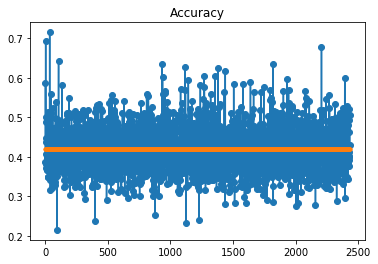

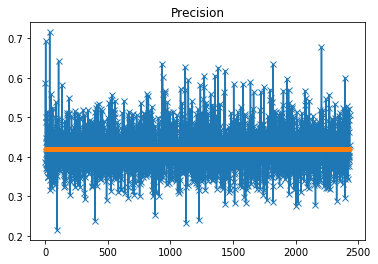

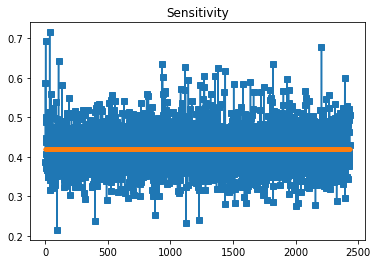

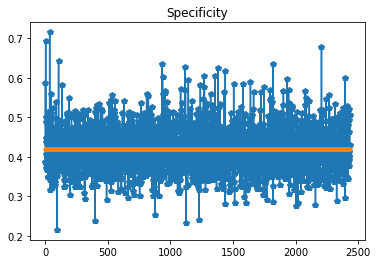

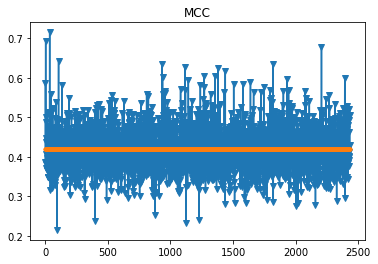

Average accuracy :  0.41978004371436906
Average precision :  0.41978004371436906
Average sensitivity :  0.41978004371436906
Average specificity :  0.41978004371436906
Average MCC :  0.41978004371436906


In [28]:
subopt = load_performances('subopt')

Loading the performances of duplex


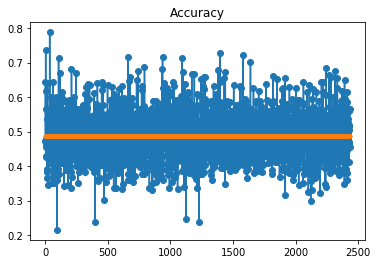

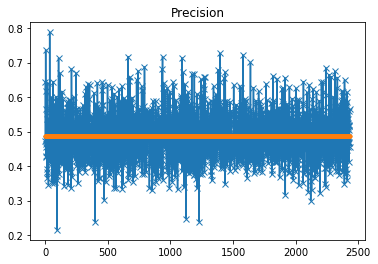

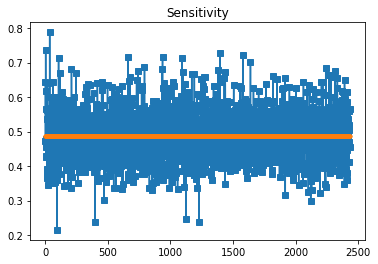

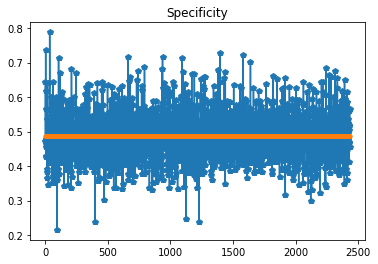

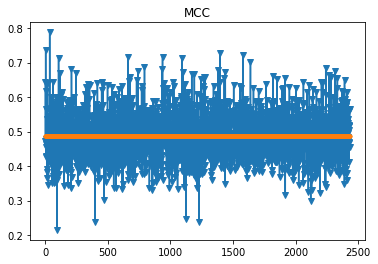

Average accuracy :  0.48785069140454757
Average precision :  0.48785069140454757
Average sensitivity :  0.48785069140454757
Average specificity :  0.48785069140454757
Average MCC :  0.48785069140454757


In [29]:
duplex = load_performances('duplex')

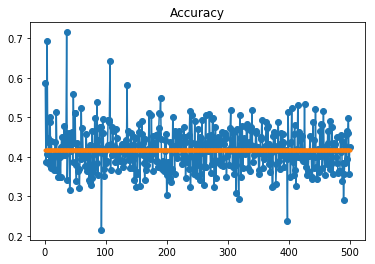

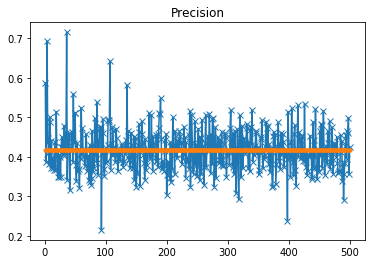

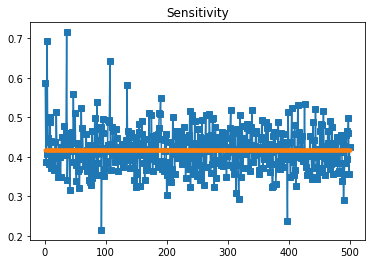

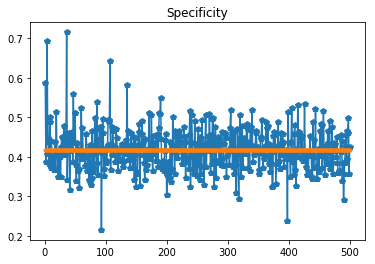

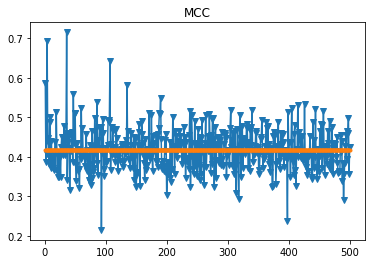

Average accuracy :  0.41818093696646813
Average precision :  0.41818093696646813
Average sensitivity :  0.41818093696646813
Average specificity :  0.41818093696646813
Average MCC :  0.41818093696646813


In [30]:
plot_performances(subopt, 500)

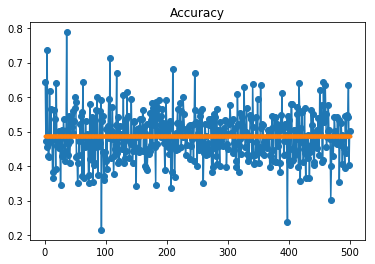

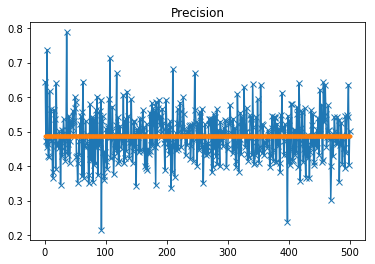

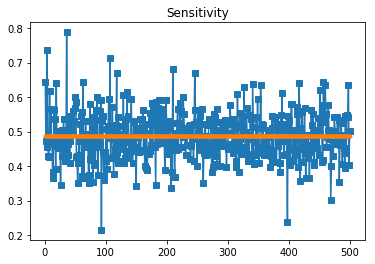

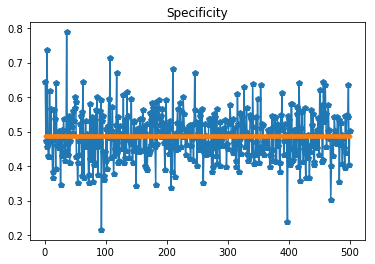

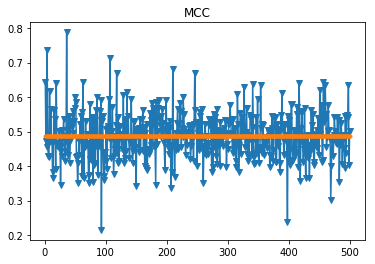

Average accuracy :  0.4860947793479295
Average precision :  0.4860947793479295
Average sensitivity :  0.4860947793479295
Average specificity :  0.4860947793479295
Average MCC :  0.4860947793479295


In [31]:
plot_performances(duplex, 500)